# 1. Anomalias

## 1.1 Cargar archivos 

In [3]:
# Carga de datos         
import pickle
import pandas as pd

# Cargar el archivo raw_data.pkl
with open(r"C:\Users\kevin.vargas\Desktop\material_formativo\5-LearningByDoing\1 - Anomalias\raw_data.pkl", "rb") as file:
    raw_data = pickle.load(file)

# Verificar el número de registros y una muestra
print(f"Número de créditos cargados: {len(raw_data)}")
first_key = list(raw_data.keys())[0]
print("Ejemplo de entrada:\n")
print(raw_data[first_key])
# vemos que efectivamente se trata de un diccionario

Número de créditos cargados: 26727
Ejemplo de entrada:

{'country': {'continent': 'EU', 'official_name': 'Spain', 'capital': 'Madrid', 'name': 'Spain', 'alpha2': 'ES', 'alpha3': 'ESP', 'numeric': '724', 'currency': {'symbol': '€', 'code': 'EUR', 'name': 'Euro', 'numeric': '978'}, 'locale': 'es-ES', 'phone_prefix': '34'}, 'total_amount': 148.27, 'created': '2018-12-08T09:35:07.751401Z', 'merchant': {'activity': {'code': '10', 'name': 'Informatica y Electrónica'}, 'id': '776b630e228e499c83b66f8f0ddaab18'}, 'checkout': {'origin': 'online', 'user_agent': {'device_model': '', 'os_family': 'windows', 'is_mobile': False, 'is_tablet': False, 'device_brand': '', 'is_pc': True, 'os_version': '10', 'device_family': 'other', 'browser_family': 'Chrome', 'browser_version': '70.0.3538', 'value': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.110 Safari/537.36', 'is_touch_capable': False}, 'customer': {'birthday': '1954-02-03', 'address': {'region': 'Cata

In [4]:
# Convertir el diccionario en un DataFrame
df = pd.DataFrame.from_dict(raw_data, orient='index').reset_index().rename(columns={'index': 'credit_id'})

# Mostrar estructura inicial
df.head(2)


credit_id   
0  9a2d10fd9e8941de98cc7de1441fdcda  \
1  d4183f2f7bde479fa22b00fc13f478d0   

                                             country  total_amount   
0  {'continent': 'EU', 'official_name': 'Spain', ...        148.27  \
1  {'continent': 'EU', 'official_name': 'Spain', ...         26.77   

                       created   
0  2018-12-08T09:35:07.751401Z  \
1  2018-12-08T09:58:42.707651Z   

                                            merchant   
0  {'activity': {'code': '10', 'name': 'Informati...  \
1  {'activity': {'code': '16', 'name': 'Mascotas'...   

                                            checkout   
0  {'origin': 'online', 'user_agent': {'device_mo...  \
1  {'origin': 'online', 'user_agent': {'device_mo...   

                                      financing_plan      target  
0  {'principal': 118.616, 'duration': 121, 'downp...  performing  
1  {'principal': 19.8912891098249, 'duration': 90...  performing

## 1.2 Desanidar columnas anidadas

Las columnas country, merchant, checkout, y financing_plan contienen diccionarios anidados. Para poder usarlas en el modelo, necesito convertirlas en columnas normales. Para ello usaré json_normalize. Una vez no estén anidadas, concateneré todo con el resto de columnas.

In [5]:
from pandas import json_normalize

# Por si acaso hago con una copia del DataFrame original
df_flat = df[['credit_id', 'country', 'merchant', 'checkout', 'financing_plan', 
              'total_amount', 'created', 'target']].copy()

# Flatten de cada columna anidada con json
df_country = json_normalize(df_flat['country'], sep='_').add_prefix('country_')
df_merchant = json_normalize(df_flat['merchant'], sep='_').add_prefix('merchant_')
df_checkout = json_normalize(df_flat['checkout'], sep='_').add_prefix('checkout_')
df_financing = json_normalize(df_flat['financing_plan'], sep='_').add_prefix('financing_')

# Concatenar todo junto con el resto de columnas no anidadas
df_final = pd.concat([
    df_flat[['credit_id', 'total_amount', 'created', 'target']],
    df_country,
    df_merchant,
    df_checkout,
    df_financing
], axis=1)

# Mostrar dimensiones y algunas columnas
print("DataFrame listo:", df_final.shape)
df_final.head(10)


DataFrame listo: (26727, 50)


credit_id  total_amount   
0  9a2d10fd9e8941de98cc7de1441fdcda        148.27  \
1  d4183f2f7bde479fa22b00fc13f478d0         26.77   
2  339c4435b0e0461eb7d8149d702bf88a        155.99   
3  68a840a4725144118aca09513a5db11b        189.00   
4  5ed94ecd629e4d65a76e6d32aedf8fa5        482.79   
5  8fccd4ec939848a1a9cd88890c01fb12        269.00   
6  63ea83fb7d414dac83cd7814f4c178ab        117.90   
7  a70858b86fd64e6f8db0e82ea2d3d4f2        104.90   
8  db3c872b26434c1c965b74dd2aa65d22        203.92   
9  261acd6b1733442bb554bd6264a9b0dc         71.34   

                       created      target country_continent   
0  2018-12-08T09:35:07.751401Z  performing                EU  \
1  2018-12-08T09:58:42.707651Z  performing                EU   
2  2018-12-08T09:38:55.413728Z  performing                EU   
3  2018-12-08T11:56:24.190451Z  performing                EU   
4  2018-12-08T09:09:19.901214Z  performing                EU   
5  2018-12-08T09:13:44.291689Z  performing                EU   
6  2018-12-08T01:07:02.747884Z  performing                EU   
7  2018-12-08T08:19:13.503292Z  performing                EU   
8  2018-12-08T00:23:24.348616Z  performing                EU   
9  2018-12-07T21:59:52.869342Z  performing                EU   

  country_official_name country_capital country_name country_alpha2   
0                 Spain          Madrid        Spain             ES  \
1                 Spain          Madrid        Spain             ES   
2                 Spain          Madrid        Spain             ES   
3                 Spain          Madrid        Spain             ES   
4                 Spain          Madrid        Spain             ES   
5                 Spain          Madrid        Spain             ES   
6                 Spain          Madrid        Spain             ES   
7                 Spain          Madrid        Spain             ES   
8                 Spain          Madrid        Spain             ES   
9                 Spain          Madrid        Spain             ES   

  country_alpha3  ... financing_duration financing_downpayment_amount   
0            ESP  ...                121                        29.65  \
1            ESP  ...                 90                         6.88   
2            ESP  ...                182                        22.28   
3            ESP  ...                274                        18.90   
4            ESP  ...                361                        40.55   
5            ESP  ...                365                        23.04   
6            ESP  ...                127                        24.35   
7            ESP  ...                365                         8.99   
8            ESP  ...                367                        15.69   
9            ESP  ...                335                         6.56   

  financing_total_interest_amount financing_annual_percentage_rate   
0                        0.000000                         0.000000  \
1                        0.744844                        24.500000   
2                        0.000000                         0.000000   
3                        0.000000                         0.000000   
4                       44.401573                        20.000000   
5                       30.545446                        24.500000   
6                        3.847208                        19.559581   
7                       11.911588                        24.500000   
8                        0.000000                         0.000000   
9                        7.405895                        24.500000   

  financing_customer_fee_tax_rate financing_total_tax_amount   
0                            21.0                        0.0  \
1                            21.0                        0.0   
2                            21.0                        0.0   
3                             0.0                        0.0   
4                             0.0                        0.0

## 1.3 Análisis exploratorio

### Función general

 Info general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26727 entries, 0 to 26726
Data columns (total 50 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   credit_id                             26727 non-null  object 
 1   total_amount                          26727 non-null  float64
 2   created                               26727 non-null  object 
 3   target                                26727 non-null  object 
 4   country_continent                     26727 non-null  object 
 5   country_official_name                 26727 non-null  object 
 6   country_capital                       26727 non-null  object 
 7   country_name                          26727 non-null  object 
 8   country_alpha2                        26727 non-null  object 
 9   country_alpha3                        26727 non-null  object 
 10  country_numeric                       26727 non-null  object 
 11  

None


 Filas: 26727  |  Columnas: 50

  Columnas duplicadas: 0

 Tipos de columnas:
Numéricas (12): ['total_amount', 'checkout_user_agent', 'financing_principal', 'financing_duration', 'financing_downpayment_amount', 'financing_total_interest_amount', 'financing_annual_percentage_rate', 'financing_customer_fee_tax_rate', 'financing_total_tax_amount', 'financing_daily_interest_per_cent', 'financing_instalment_amount', 'financing_num_instalments']
Categóricas (38): ['credit_id', 'created', 'target', 'country_continent', 'country_official_name', 'country_capital', 'country_name', 'country_alpha2', 'country_alpha3', 'country_numeric', 'country_locale', 'country_phone_prefix', 'country_currency_symbol', 'country_currency_code', 'country_currency_name', 'country_currency_numeric', 'merchant_id', 'merchant_activity_code', 'merchant_activity_name', 'merchant_activity_name_es', 'merchant_activity_name_en', 'checkout_origin', 'checkout_user_agent_device_model', 'checkout_user_agent_os_family', 'check

total_amount  checkout_user_agent  financing_principal   
count  26727.000000                  0.0         26727.000000  \
mean     363.783704                  NaN           288.146210   
std      426.207521                  NaN           366.558646   
min        0.800000                  NaN             0.005740   
25%      122.310000                  NaN            86.752256   
50%      222.040000                  NaN           168.458784   
75%      427.785000                  NaN           337.392259   
max     3686.340000                  NaN          2865.927731   

       financing_duration  financing_downpayment_amount   
count        26727.000000                  26727.000000  \
mean           199.837505                     66.991562   
std            118.875399                     95.940822   
min              0.000000                      0.190000   
25%            119.000000                     23.295000   
50%            162.000000                     40.000000   
75%            336.000000                     75.635000   
max            758.000000                   2239.090000   

       financing_total_interest_amount  financing_annual_percentage_rate   
count                     26727.000000                      26727.000000  \
mean                         15.200610                         18.603670   
std                          28.616398                          9.849386   
min                           0.000000                         -0.000255   
25%                           1.066514                         20.000000   
50%                           5.199420                         24.500000   
75%                          16.797996                         24.500000   
max                         655.136030                        244.826455   

       financing_customer_fee_tax_rate  financing_total_tax_amount   
count                     26727.000000                     26727.0  \
mean                          9.151308                         0.0   
std                          10.413217                         0.0   
min                           0.000000                         0.0   
25%                           0.000000                         0.0   
50%                           0.000000                         0.0   
75%                          21.000000                         0.0   
max                          21.000000                         0.0   

       financing_daily_interest_per_cent  financing_instalment_amount   
count                       26727.000000                 26727.000000  \
mean                            0.055810                    53.951505   
std                             0.012128                   100.557838   
min                             0.000000                     0.001170   
25%                             0.060055                    17.958051   
50%                             0.060055                    32.218629   
75%                             0.060055                    59.103906   
max                             0.060055                  2079.999963   

       financing_num_instalments  
count               26727.000000  
mean                    6.667976  
std                     3.914561  
min                     1.000000  
25%                     4.000000  
50%                     6.000000  
75%                    11.000000  
max                    24.000000


 Valores nulos por columna:


credit_id                                   0
total_amount                                0
created                                     0
target                                      0
country_continent                           0
country_official_name                       0
country_capital                             0
country_name                                0
country_alpha2                              0
country_alpha3                              0
country_numeric                             0
country_locale                              0
country_phone_prefix                        0
country_currency_symbol                     0
country_currency_code                       0
country_currency_name                       0
country_currency_numeric                    0
merchant_id                                 0
merchant_activity_code                      0
merchant_activity_name                      0
merchant_activity_name_es               20369
merchant_activity_name_en         


 Distribución de columnas numéricas:


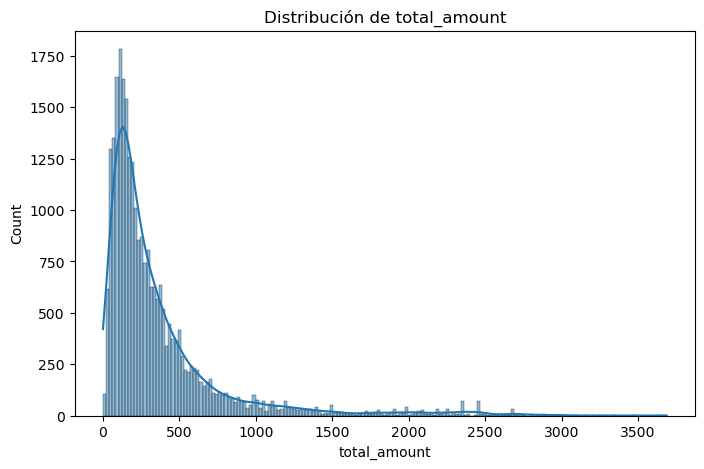

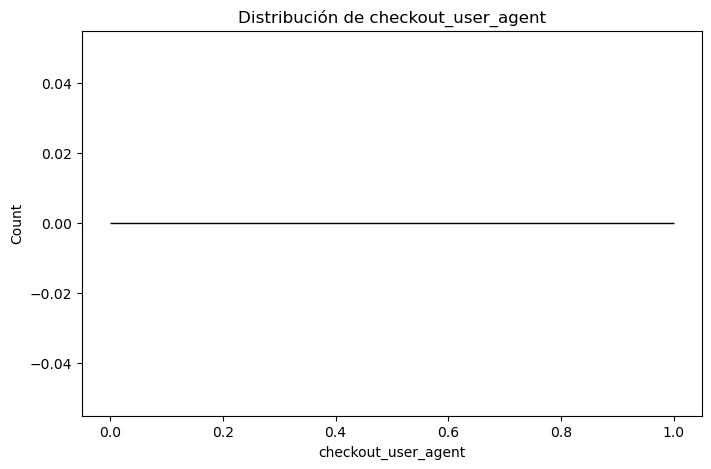

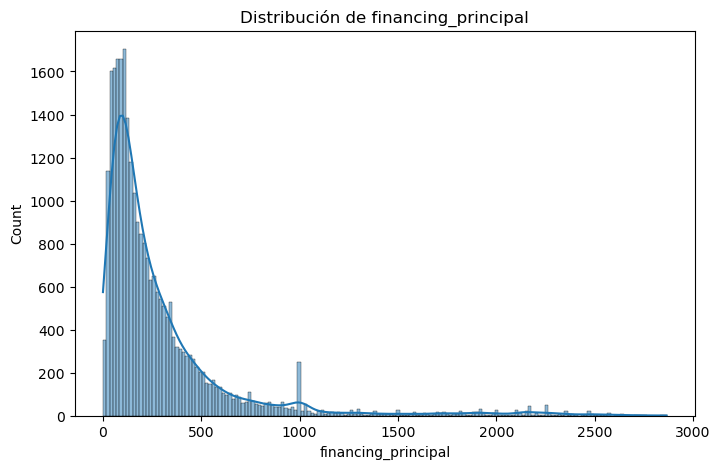

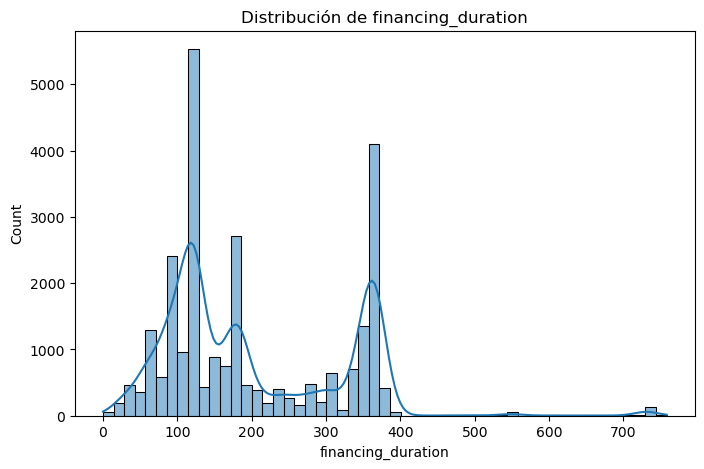

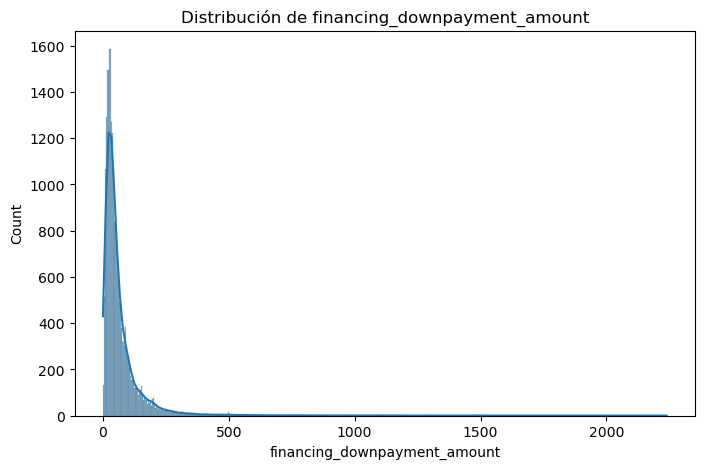

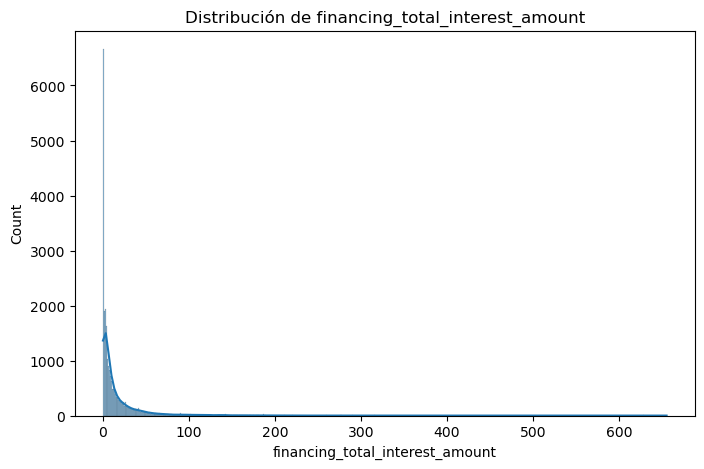

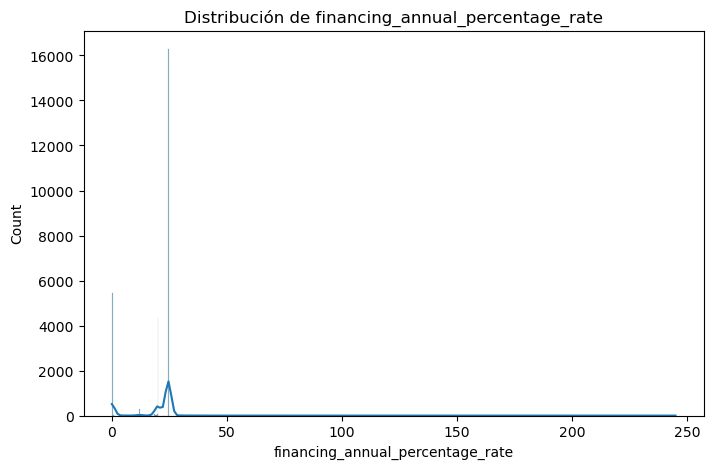

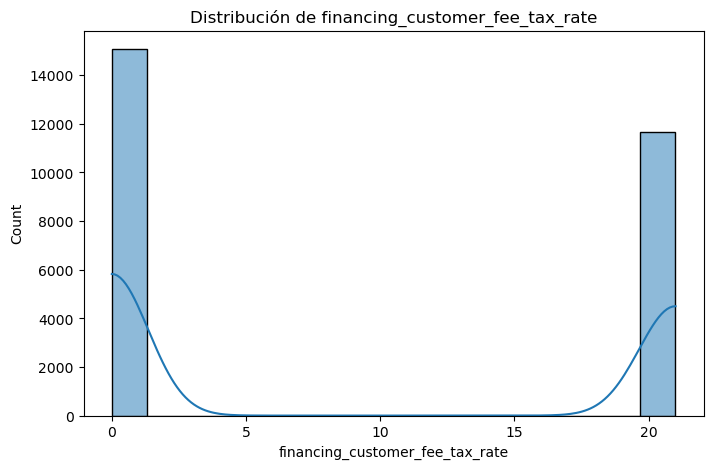

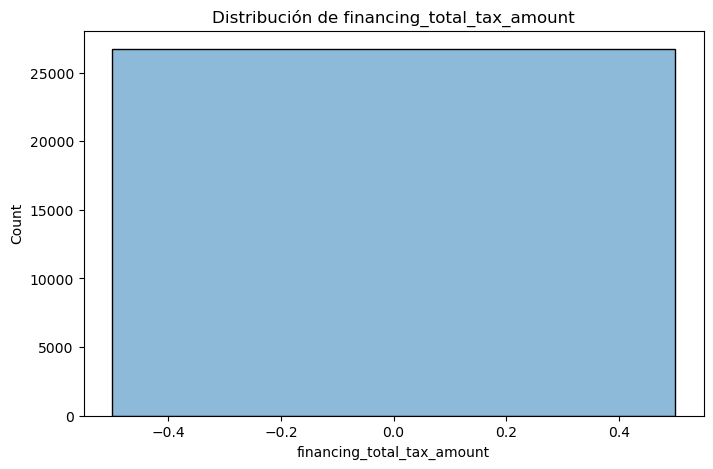

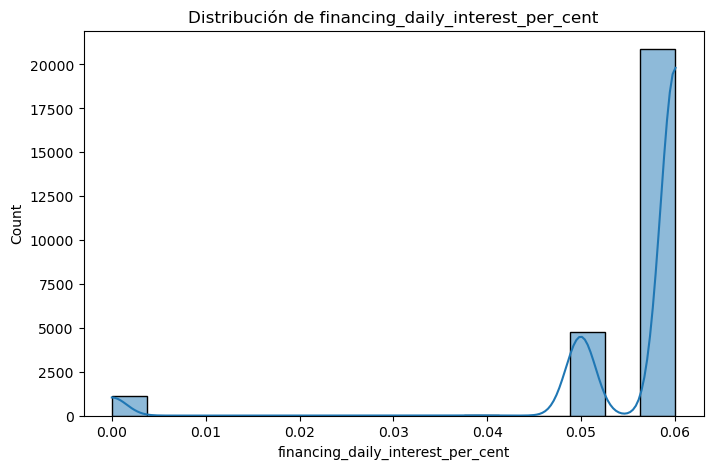

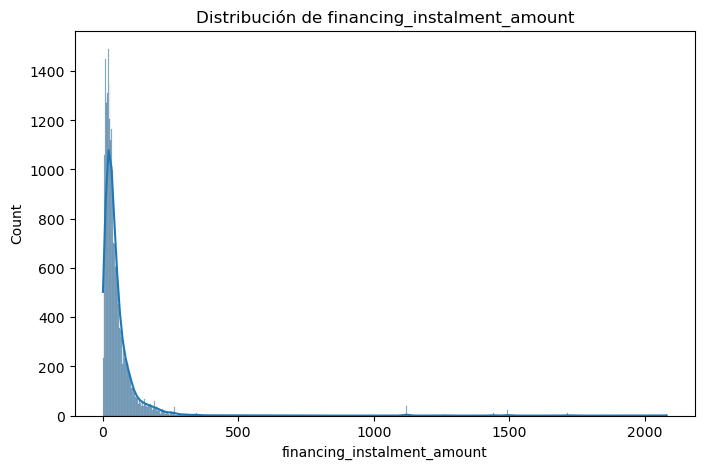

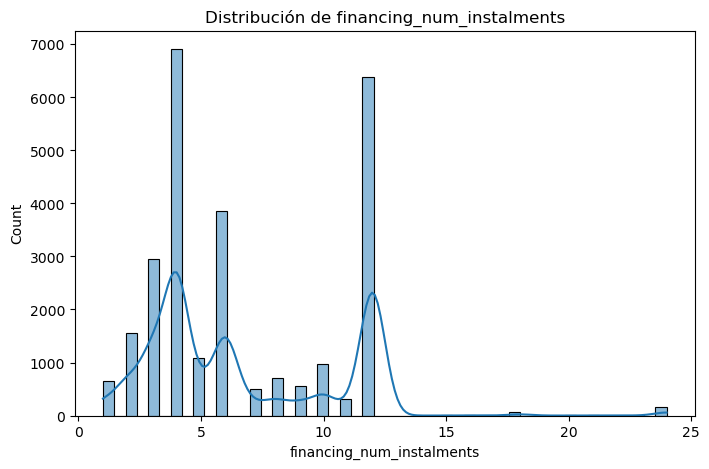


 Distribución de columnas categóricas:


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x0000011E9FEF4670> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



Error in callback <function flush_figures at 0x0000011EA19F9550> (for post_execute), with arguments args (),kwargs {}:

In [ ]:
import sys
sys.path.append(r'C:\Users\kevin.vargas\Desktop\ds_kevin_vargas\Funciones')

from eda_utils import basic_eda

basic_eda(df_final)

### Valores nulos

In [6]:
# Valores nulos absolutos y relativos (%)
nulls_abs = df_final.isnull().sum()
nulls_pct = (nulls_abs / len(df_final)) * 100

# Crear tabla resumen ordenada
nulls_df = pd.DataFrame({
    'missing_count': nulls_abs,
    'missing_pct': nulls_pct
}).sort_values(by='missing_pct', ascending=False)

# Mostrar solo las columnas con algún valor nulo
nulls_df[nulls_df['missing_count'] > 0]
nulls_df


missing_count  missing_pct
checkout_user_agent                           26727   100.000000
merchant_activity_name_en                     20369    76.211322
merchant_activity_name_es                     20369    76.211322
checkout_user_agent_is_mobile                  1317     4.927601
checkout_user_agent_is_pc                      1317     4.927601
checkout_user_agent_is_tablet                  1317     4.927601
checkout_user_agent_os_version                 1317     4.927601
checkout_user_agent_os_family                  1317     4.927601
checkout_user_agent_device_model               1317     4.927601
checkout_user_agent_device_family              1317     4.927601
checkout_user_agent_browser_family             1317     4.927601
checkout_user_agent_browser_version            1317     4.927601
checkout_user_agent_value                      1317     4.927601
checkout_user_agent_is_touch_capable           1317     4.927601
checkout_user_agent_device_brand               1317     4.927601
checkout_customer_birthday                        0     0.000000
checkout_customer_document_id_type                0     0.000000
financing_principal                               0     0.000000
financing_duration                                0     0.000000
financing_downpayment_amount                      0     0.000000
financing_total_interest_amount                   0     0.000000
financing_annual_percentage_rate                  0     0.000000
financing_customer_fee_tax_rate                   0     0.000000
financing_total_tax_amount                        0     0.000000
financing_daily_interest_per_cent                 0     0.000000
financing_instalment_amount                       0     0.000000
financing_first_payment_date                      0     0.000000
checkout_customer_address_region                  0     0.000000
credit_id                                         0     0.000000
total_amount                                      0     0.000000
country_numeric                                   0     0.000000
created                                           0     0.000000
target                                            0     0.000000
country_continent                                 0     0.000000
country_official_name                             0     0.000000
country_capital                                   0     0.000000
country_name                                      0     0.000000
country_alpha2                                    0     0.000000
country_alpha3                                    0     0.000000
country_locale                                    0     0.000000
checkout_origin                                   0     0.000000
country_phone_prefix                              0     0.000000
country_currency_symbol                           0     0.000000
country_currency_code                             0     0.000000
country_currency_name                             0     0.000000
country_currency_numeric                          0     0.000000
merchant_id                                       0     0.000000
merchant_activity_code                            0     0.000000
merchant_activity_name                            0     0.000000
financing_num_instalments                         0     0.000000

1. checkout_user_agent — 100% nulos
Tipo: contiene el JSON completo del user agent (ya lo desanidé)

        Acción: Eliminar. No aporta nada y está totalmente vacío.


2. merchant_activity_name_en, merchant_activity_name_es — 76% nulos
Tipo: descripciones del sector del comercio

        Acción: Eliminar las versiones en y es (son redundantes y casi vacías)


3. Variables de checkout_user_agent_* — ~5% nulos
Ejemplos: device_model, browser_version, os_family, is_mobile, etc.

        Acción: Mantenerlas, porque en su mayoría están bien. Imputar con 'unknown' (para strings) o False/True (para booleanos), según convenga

### Variable objetivo target

Conteo absoluto:
target
performing     24527
credit_risk     2001
fraud_risk       199
Name: count, dtype: int64

Distribución porcentual:
target
performing     91.768623
credit_risk     7.486811
fraud_risk      0.744565
Name: proportion, dtype: float64


C:\Users\kevin.vargas\AppData\Local\Temp\ipykernel_20872\3112474785.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_final, x='target', palette='Set2')


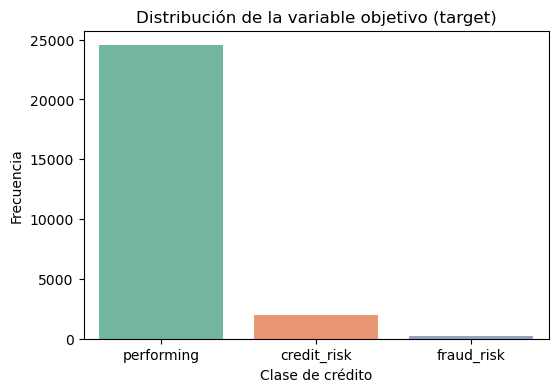

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Conteo absoluto y relativo
print("Conteo absoluto:")
print(df_final['target'].value_counts())
print("\nDistribución porcentual:")
print(df_final['target'].value_counts(normalize=True) * 100)

# Gráfico
plt.figure(figsize=(6,4))
sns.countplot(data=df_final, x='target', palette='Set2')
plt.title('Distribución de la variable objetivo (target)')
plt.xlabel('Clase de crédito')
plt.ylabel('Frecuencia')
plt.show()


¿Qué consecuencias tiene? Consecuencias muy importantes porque nos encontramos ante una variable con desbalance muy alto. 
- Si uso accuracy como métrica, un modelo que siempre prediga performing tendría ~92% de acierto… pero sería inútil.

- Las clases minoritarias (credit_risk, fraud_risk) son precisamente las más importantes para x negocio.

- El modelo debe detectar anomalías, aunque haya pocos ejemplos y es justamente el problema que me encuentro aqui. 

¿Qué opciones tengo?
1. Usar métricas robustas:
- precision, recall, f1-score por clase

- confusion_matrix

- Macro/micro averaged f1-score

2. Rebalanceo de clases:
Podría hacerlo de dos maneras (complementarias):

a) Durante el entrenamiento
- Si usase modelos de Scikit-learn como RandomForestClassifier, LogisticRegression, etc.: tendría que especificar (class_weight='balanced'), lo que le diria al modelo es que de mas importancia a las clases raras. Calcularia un peso inversamente proporcional a la frecuencia de cada clase. Le daria mas peso a las clases menos frecuentes y cuando el modelo falle al predecir esos pesos penalizara mas. 


b) Rebalanceo en los datos al Usar sobremuestreo (SMOTE) o submuestreo


Habrá 3 tacticas a utilizar:

- Empezar con class_weight='balanced' solo.
➜ Medida base. Podría ver cuánto mejora sin tocar datos.

- Probar SMOTE parcial (ej. 70-30) + class_weight='balanced'.
➜ Generalmente la mejor opción en casos extremos como el mio por el balance.

- (Opcional) Por ultimo como curiosidad podria probar SMOTE total sin class_weight.
➜ Compararé si merece la pena balancear del todo o no.

## 1.4 Limpieza de datos

### Valores nulos

In [8]:
#Eliminare la columna porque ya no aporta nada y esta totalmente vacia y otras porque son redundantes y casi vacias
# Eliminar columnas irrelevantes o vacías
df_final.drop(columns=[
    'checkout_user_agent',
    'merchant_activity_name_en',
    'merchant_activity_name_es',
    'financing_total_tax_amount'  # Agregar esta
], inplace=True)



In [9]:
# Sustituir con unkwown para categoricas y booleanos para numericas
# Para strings/categorías
cols_str = [
    'checkout_user_agent_os_family',
    'checkout_user_agent_browser_family',
    'checkout_user_agent_browser_version',
    'checkout_user_agent_device_model',
    'checkout_user_agent_device_family',
    'checkout_user_agent_device_brand',
    'checkout_user_agent_value',
    'checkout_user_agent_os_version'
]

for col in cols_str:
    df_final[col].fillna('unknown', inplace=True)

# Para booleanos
cols_bool = [
    'checkout_user_agent_is_mobile',
    'checkout_user_agent_is_pc',
    'checkout_user_agent_is_tablet',
    'checkout_user_agent_is_touch_capable'
]

for col in cols_bool:
    df_final[col].fillna(False, inplace=True)


In [10]:
# COMPROBAR NUEVAMENTE EL CONTEO DE VALORES NULOS
# Valores nulos absolutos y relativos (%)
nulls_abs = df_final.isnull().sum()
nulls_pct = (nulls_abs / len(df_final)) * 100

# Crear tabla resumen ordenada
nulls_df = pd.DataFrame({
    'missing_count': nulls_abs,
    'missing_pct': nulls_pct
}).sort_values(by='missing_pct', ascending=False)

# Mostrar solo las columnas con algún valor nulo
nulls_df[nulls_df['missing_count'] > 0]
nulls_df

missing_count  missing_pct
credit_id                                         0          0.0
checkout_customer_address_region                  0          0.0
checkout_user_agent_device_brand                  0          0.0
checkout_user_agent_is_pc                         0          0.0
checkout_user_agent_os_version                    0          0.0
checkout_user_agent_device_family                 0          0.0
checkout_user_agent_browser_family                0          0.0
checkout_user_agent_browser_version               0          0.0
checkout_user_agent_value                         0          0.0
checkout_user_agent_is_touch_capable              0          0.0
checkout_customer_birthday                        0          0.0
checkout_customer_document_id_type                0          0.0
total_amount                                      0          0.0
financing_principal                               0          0.0
financing_duration                                0          0.0
financing_downpayment_amount                      0          0.0
financing_total_interest_amount                   0          0.0
financing_annual_percentage_rate                  0          0.0
financing_customer_fee_tax_rate                   0          0.0
financing_daily_interest_per_cent                 0          0.0
financing_instalment_amount                       0          0.0
financing_first_payment_date                      0          0.0
checkout_user_agent_is_tablet                     0          0.0
checkout_user_agent_is_mobile                     0          0.0
checkout_user_agent_os_family                     0          0.0
checkout_user_agent_device_model                  0          0.0
created                                           0          0.0
target                                            0          0.0
country_continent                                 0          0.0
country_official_name                             0          0.0
country_capital                                   0          0.0
country_name                                      0          0.0
country_alpha2                                    0          0.0
country_alpha3                                    0          0.0
country_numeric                                   0          0.0
country_locale                                    0          0.0
country_phone_prefix                              0          0.0
country_currency_symbol                           0          0.0
country_currency_code                             0          0.0
country_currency_name                             0          0.0
country_currency_numeric                          0          0.0
merchant_id                                       0          0.0
merchant_activity_code                            0          0.0
merchant_activity_name                            0          0.0
checkout_origin                                   0          0.0
financing_num_instalments                         0          0.0

## 1.5 Feature engineering

### 1.5.1 Variables temporales dedicadas

#### Edad del cliente

In [11]:
# Convertir a datetime y quitar zona horaria
df_final['created'] = pd.to_datetime(df_final['created']).dt.tz_localize(None)
df_final['checkout_customer_birthday'] = pd.to_datetime(df_final['checkout_customer_birthday'])

# Calcular edad del cliente
df_final['customer_age'] = (df_final['created'] - df_final['checkout_customer_birthday']).dt.days // 365


#### Días entre solicitud y primer pago

In [12]:
df_final['financing_first_payment_date'] = pd.to_datetime(df_final['financing_first_payment_date'])
df_final['days_to_first_payment'] = (df_final['financing_first_payment_date'] - df_final['created']).dt.days


#### Features del momento de la creación de la solicitud

In [13]:
df_final['created_month'] = df_final['created'].dt.month
df_final['created_day'] = df_final['created'].dt.day
df_final['created_weekday'] = df_final['created'].dt.weekday  # 0 = lunes
df_final['created_hour'] = df_final['created'].dt.hour


#### Eliminar columnas que ya no son necesarias

In [14]:
df_final.drop(columns=[
    'checkout_customer_birthday',
    'created',
    'financing_first_payment_date'
], inplace=True)


#### Eliminar errores en alguna columna

In [15]:
# Eliminar casos con valores negativos
df_final = df_final[df_final['days_to_first_payment'] >= 0]
#Esto es debido a que en days to first payment encuentro un valor negativo por lo que no tiene sentido mantenerlo,supondría haber pagado antes de tiempo.
df_final

credit_id  total_amount       target   
0      9a2d10fd9e8941de98cc7de1441fdcda        148.27   performing  \
1      d4183f2f7bde479fa22b00fc13f478d0         26.77   performing   
2      339c4435b0e0461eb7d8149d702bf88a        155.99   performing   
3      68a840a4725144118aca09513a5db11b        189.00   performing   
4      5ed94ecd629e4d65a76e6d32aedf8fa5        482.79   performing   
...                                 ...           ...          ...   
26722  24d9e960b53345429f85d641520b2bfb       2244.85  credit_risk   
26723  0e3b7e2935c34c8abddacc1ace481f2a       1200.00   performing   
26724  bd79cf38ff6043d1a118c03687ef5160       2800.00   performing   
26725  92733ac0ee084410a72c66e7710f1ad4       2684.88   performing   
26726  4ca19630e6744267964b4bcb0d8d1b34       1995.00   performing   

      country_continent country_official_name country_capital country_name   
0                    EU                 Spain          Madrid        Spain  \
1                    EU                 Spain          Madrid        Spain   
2                    EU                 Spain          Madrid        Spain   
3                    EU                 Spain          Madrid        Spain   
4                    EU                 Spain          Madrid        Spain   
...                 ...                   ...             ...          ...   
26722                EU                 Spain          Madrid        Spain   
26723                EU                 Spain          Madrid        Spain   
26724                EU                 Spain          Madrid        Spain   
26725                EU                 Spain          Madrid        Spain   
26726                EU                 Spain          Madrid        Spain   

      country_alpha2 country_alpha3 country_numeric  ...   
0                 ES            ESP             724  ...  \
1                 ES            ESP             724  ...   
2                 ES            ESP             724  ...   
3                 ES            ESP             724  ...   
4                 ES            ESP             724  ...   
...              ...            ...             ...  ...   
26722             ES            ESP             724  ...   
26723             ES            ESP             724  ...   
26724             ES            ESP             724  ...   
26725             ES            ESP             724  ...   
26726             ES            ESP             724  ...   

      financing_customer_fee_tax_rate financing_daily_interest_per_cent   
0                                21.0                          0.060055  \
1                                21.0                          0.060055   
2                                21.0                          0.060055   
3                                 0.0                          0.060055   
4                                 0.0                          0.049964   
...                               ...                               ...   
26722                             0.0                          0.060055   
26723                            21.0                          0.000000   
26724                             0.0                          0.060055   
26725                             0.0                          0.060055   
26726                             0.0                          0.060055   

      financing_instalment_amount financing_num_instalments customer_age   
0                       29.654000                         4           64  \
1                        6.878711                         3           27   
2                       22.284286                         6           26   
3                       18.900000                         9           38   
4                       40.553198                        12           59   
...                           ...                       ...          ...   
26722                  118.150000                        16           41   
26723                 

## 1.6 Codificación de variables

### Identificar columnas categóricas

In [16]:
cat_cols = df_final.select_dtypes(include='object').columns.tolist()
cat_cols.remove('target')  # No codifico la variable objetivo
print(cat_cols)


['credit_id', 'country_continent', 'country_official_name', 'country_capital', 'country_name', 'country_alpha2', 'country_alpha3', 'country_numeric', 'country_locale', 'country_phone_prefix', 'country_currency_symbol', 'country_currency_code', 'country_currency_name', 'country_currency_numeric', 'merchant_id', 'merchant_activity_code', 'merchant_activity_name', 'checkout_origin', 'checkout_user_agent_device_model', 'checkout_user_agent_os_family', 'checkout_user_agent_device_brand', 'checkout_user_agent_os_version', 'checkout_user_agent_device_family', 'checkout_user_agent_browser_family', 'checkout_user_agent_browser_version', 'checkout_user_agent_value', 'checkout_customer_address_region', 'checkout_customer_document_id_type']


### Frecuencia de categorias

In [17]:
for col in cat_cols:
    print(f"\n {col} - {df_final[col].nunique()} categorías únicas")
    print(df_final[col].value_counts(dropna=False).head(10))



 credit_id - 26726 categorías únicas
credit_id
9a2d10fd9e8941de98cc7de1441fdcda    1
b369c4e27274497e9966ef86eeaf0297    1
994227c3c529440b84708dc1cd526e21    1
ad206f15beb3475e8d2d69a0fb9f5d21    1
006b33af71b54589af976d338fcff4ba    1
c822e2735bd54b43b26b52c47f2d6ba7    1
58162e324a354766a90a21faf5104727    1
08db8297bc6f43b0b7cfc399c4ed8590    1
bdb6b4829b68435db06ecb43764b1a1b    1
16d0f3d1a8334a21a7b7a93b8ea4fdb2    1
Name: count, dtype: int64

 country_continent - 1 categorías únicas
country_continent
EU    26726
Name: count, dtype: int64

 country_official_name - 1 categorías únicas
country_official_name
Spain    26726
Name: count, dtype: int64

 country_capital - 1 categorías únicas
country_capital
Madrid    26726
Name: count, dtype: int64

 country_name - 1 categorías únicas
country_name
Spain    26726
Name: count, dtype: int64

 country_alpha2 - 1 categorías únicas
country_alpha2
ES    26726
Name: count, dtype: int64

 country_alpha3 - 1 categorías únicas
country_alpha3
ESP 

¿Por qué eliminar todas las columnas country_*?
En mi análisis se ve que todas estas columnas tienen solo un único valor en todas las filas:

country_name	Spain
country_alpha2	ES
country_currency	Euro
country_locale	es-ES

¿Qué pasa cuando una variable solo tiene un valor?
- No aporta ninguna información discriminativa al modelo.

- Es como tener una columna que dice "España" en todas las filas.

- A nivel estadístico, tiene varianza nula → no ayuda a separar clases.

- Puede incluso aumentar el ruido y el tiempo de cómputo.

Conclusión:

Si una variable no varía, no informa → y por tanto, se elimina siempre en Machine Learning.

Es exactamente lo mismo que eliminar una columna que siempre tiene un 0, un True, o una misma palabra.



### Eliminar columnas
Vamos a eliminar todas las columnas que no transmitan informacion (aquellas donde todos sus valores sean los mismos)

In [18]:
cols_to_drop = [
    # ID irrelevante o con demasiada cardinalidad
    'credit_id',
    'checkout_user_agent_value',

    # Columnas constantes (solo España)
    'country_continent', 'country_official_name', 'country_capital', 'country_name',
    'country_alpha2', 'country_alpha3', 'country_numeric', 'country_locale',
    'country_phone_prefix', 'country_currency_symbol', 'country_currency_code',
    'country_currency_name', 'country_currency_numeric',

    # Columnas muy granulares sin valor añadido
    'checkout_user_agent_browser_version',
    'checkout_user_agent_os_version'
]

df_final.drop(columns=cols_to_drop, inplace=True)
df_final


total_amount       target                       merchant_id   
0            148.27   performing  776b630e228e499c83b66f8f0ddaab18  \
1             26.77   performing  94095397bf6e449e8332ac678040ab70   
2            155.99   performing  776b630e228e499c83b66f8f0ddaab18   
3            189.00   performing  e2f9246b7b9e432fb07372c1b1d36dcc   
4            482.79   performing  513f1c5b8be0415497902ee716840403   
...             ...          ...                               ...   
26722       2244.85  credit_risk  7d9ba35904ef4552a356a2f0f93869c3   
26723       1200.00   performing  ab99e826f7ab4f8987d8cf7d0ea37579   
26724       2800.00   performing  085d07df19a14ea28a2a923bcb6c323a   
26725       2684.88   performing  6909ac8bc4884cdbbd7bea25e0a1d5d1   
26726       1995.00   performing  7d9ba35904ef4552a356a2f0f93869c3   

      merchant_activity_code     merchant_activity_name checkout_origin   
0                         10  Informatica y Electrónica          online  \
1                         16                   Mascotas          online   
2                         10  Informatica y Electrónica          online   
3                         17        Moda y Complementos          online   
4                          9         Hogar y Decoración          online   
...                      ...                        ...             ...   
26722                      5     Education and Training          online   
26723                      9             Home and Decor          online   
26724                      5     Education and Training          online   
26725                      5     Education and Training          online   
26726                      5     Education and Training          online   

      checkout_user_agent_device_model checkout_user_agent_os_family   
0                                                            windows  \
1                           Smartphone                       android   
2                               iPhone                           ios   
3                               iPhone                           ios   
4                               iPhone                           ios   
...                                ...                           ...   
26722                                                        windows   
26723                       Smartphone                       android   
26724                                                        windows   
26725                                                        windows   
26726                          unknown                       unknown   

       checkout_user_agent_is_mobile  checkout_user_agent_is_tablet  ...   
0                              False                          False  ...  \
1                               True                          False  ...   
2                               True                          False  ...   
3                               True                          False  ...   
4                               True                          False  ...   
...                              ...                            ...  ...   
26722                          False                          False  ...   
26723                          False                           True  ...   
26724                          False                          False  ...   
26725                          False                          False  ...   
26726                          False                          False  ...   

      financing_customer_fee_tax_rate  financing_daily_interest_per_cent   
0                                21.0                           0.060055  \
1                                21.0                           0.060055   
2                                21.0                           0.060055   
3                                 0.0                           0.060055   
4                                 0.0                           0.049964   
...                            

### OneHotEncoder

In [ ]:
# Agrupar los merchant_id más frecuentes y agrupar el resto en 'other'
#top_merchant_ids = df_final['merchant_id'].value_counts().nlargest(10).index
#df_final['merchant_id'] = df_final['merchant_id'].apply(lambda x: x if x in top_merchant_ids else 'other')

# Agrupar los device_model más frecuentes y agrupar el resto en 'other'
#top_device_models = df_final['checkout_user_agent_device_model'].value_counts().nlargest(10).index
#df_final['checkout_user_agent_device_model'] = df_final['checkout_user_agent_device_model'].apply(
   # lambda x: x if x in top_device_models else 'other'
#)

# Agrupar los device_family más frecuentes y agrupar el resto en 'other'
#top_device_families = df_final['checkout_user_agent_device_family'].value_counts().nlargest(10).index
#df_final['checkout_user_agent_device_family'] = df_final['checkout_user_agent_device_family'].apply(
#    lambda x: x if x in top_device_families else 'other'
#)



In [19]:
# Estas sí aplican umbral
cols_with_umbral = [
    'merchant_id',
    'checkout_user_agent_device_model',
    'checkout_user_agent_device_family',
    'merchant_activity_name',
    'checkout_user_agent_os_family',
    'merchant_activity_code',
    'checkout_user_agent_device_brand',
    'checkout_user_agent_browser_family',
    'checkout_customer_address_region' # revisar y limpiar
]

# Estas no agrupan nada porque tienen pocas categorías y todas útiles
cols_no_umbral = [
    
    'checkout_origin',
    
    
    
    'checkout_customer_document_id_type'
]

df_encoded = df_final.copy()

# Aplicar agrupación para columnas con umbral
umbral_min = 600
for col in cols_with_umbral:
    freqs = df_encoded[col].value_counts()
    categorias_validas = freqs[freqs >= umbral_min].index
    df_encoded[col] = df_encoded[col].apply(lambda x: x if x in categorias_validas else 'Otros')

# Agrupamos todas para OneHot
onehot_cols = cols_with_umbral + cols_no_umbral


In [20]:
from sklearn.preprocessing import OneHotEncoder

# Aplicar OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first') #he añadido drop first

df_ohe = pd.DataFrame(
    ohe.fit_transform(df_encoded[onehot_cols]),
    columns=ohe.get_feature_names_out(onehot_cols),
    index=df_encoded.index
)

# Concatenar con el resto del DataFrame (eliminando las columnas categóricas originales)
df_final = pd.concat([df_encoded.drop(columns=onehot_cols), df_ohe], axis=1)
df_final


c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


total_amount       target  checkout_user_agent_is_mobile   
0            148.27   performing                          False  \
1             26.77   performing                           True   
2            155.99   performing                           True   
3            189.00   performing                           True   
4            482.79   performing                           True   
...             ...          ...                            ...   
26722       2244.85  credit_risk                          False   
26723       1200.00   performing                          False   
26724       2800.00   performing                          False   
26725       2684.88   performing                          False   
26726       1995.00   performing                          False   

       checkout_user_agent_is_tablet  checkout_user_agent_is_pc   
0                              False                       True  \
1                              False                      False   
2                              False                      False   
3                              False                      False   
4                              False                      False   
...                              ...                        ...   
26722                          False                       True   
26723                           True                      False   
26724                          False                       True   
26725                          False                       True   
26726                          False                      False   

       checkout_user_agent_is_touch_capable  financing_principal   
0                                     False           118.616000  \
1                                      True            19.891289   
2                                      True           133.705714   
3                                      True           170.100000   
4                                      True           442.236802   
...                                     ...                  ...   
26722                                 False          1890.400000   
26723                                  True          1152.000000   
26724                                 False          2661.794559   
26725                                 False          2556.801394   
26726                                 False          1915.200000   

       financing_duration  financing_downpayment_amount   
0                     121                         29.65  \
1                      90                          6.88   
2                     182                         22.28   
3                     274                         18.90   
4                     361                         40.55   
...                   ...                           ...   
26722                 487                        118.15   
26723                 731                         48.00   
26724                 731                        138.21   
26725                 731                        128.08   
26726                 731                         79.80   

       financing_total_interest_amount  ...   
0                             0.000000  ...  \
1                             0.744844  ...   
2                             0.000000  ...   
3                             0.000000  ...   
4                            44.401573  ...   
...                                ...  ...   
26722                         0.000000  ...   
26723                         0.000000  ...   
26724                       655.136030  ...   
26725                       517.085140  ...   
26726                         0.000000  ...   

       checkout_customer_address_region_Comunidad Valenciana   
0                                                    0.0      \
1                                                    0.0       
2                                                    0.0       
3                                                 

### Feature engeenigring pt2

In [ ]:
#  Finanzas puras 
df_final['amount_per_instalment'] = df_final['total_amount'] / df_final['financing_num_instalments']
df_final['interest_rate_x_duration'] = df_final['financing_annual_percentage_rate'] * df_final['financing_duration']
df_final['interest_ratio'] = df_final['financing_total_interest_amount'] / df_final['total_amount']
df_final['downpayment_ratio'] = df_final['financing_downpayment_amount'] / df_final['total_amount']

#  Comportamiento temporal 
df_final['is_night_time'] = (df_final['created_hour'] < 6).astype(int)
df_final['is_weekend'] = (df_final['created_weekday'] >= 5).astype(int)
df_final['is_end_of_month'] = (df_final['created_day'] > 25).astype(int)

#  Tecnología / perfil del usuario 
df_final['mobile_and_touch'] = (
    df_final['checkout_user_agent_is_mobile'] & df_final['checkout_user_agent_is_touch_capable']
).astype(int)

tech_cols = [
    'checkout_user_agent_is_mobile',
    'checkout_user_agent_is_tablet',
    'checkout_user_agent_is_pc',
    'checkout_user_agent_is_touch_capable'
]
df_final['num_tech_flags'] = df_final[tech_cols].sum(axis=1)
df_final.head()


total_amount      target  checkout_user_agent_is_mobile   
0        148.27  performing                          False  \
1         26.77  performing                           True   
2        155.99  performing                           True   
3        189.00  performing                           True   
4        482.79  performing                           True   

   checkout_user_agent_is_tablet  checkout_user_agent_is_pc   
0                          False                       True  \
1                          False                      False   
2                          False                      False   
3                          False                      False   
4                          False                      False   

   checkout_user_agent_is_touch_capable  financing_principal   
0                                 False           118.616000  \
1                                  True            19.891289   
2                                  True           133.705714   
3                                  True           170.100000   
4                                  True           442.236802   

   financing_duration  financing_downpayment_amount   
0                 121                         29.65  \
1                  90                          6.88   
2                 182                         22.28   
3                 274                         18.90   
4                 361                         40.55   

   financing_total_interest_amount  ...   
0                         0.000000  ...  \
1                         0.744844  ...   
2                         0.000000  ...   
3                         0.000000  ...   
4                        44.401573  ...   

   checkout_customer_document_id_type_nif  amount_per_instalment   
0                                     1.0              37.067500  \
1                                     1.0               8.923333   
2                                     1.0              25.998333   
3                                     1.0              21.000000   
4                                     1.0              40.232500   

   interest_rate_x_duration  interest_ratio  downpayment_ratio  is_night_time   
0                  0.000000        0.000000           0.199973              0  \
1               2205.000000        0.027824           0.257004              0   
2                  0.000000        0.000000           0.142830              0   
3                  0.000000        0.000000           0.100000              0   
4               7220.000001        0.091969           0.083991              0   

   is_weekend  is_end_of_month  mobile_and_touch  num_tech_flags  
0           1                0                 0               1  
1           1                0                 1               2  
2           1                0                 1               2  
3           1                0                 1               2  
4           1                0                 1               2  

[5 rows x 106 columns]

In [22]:
# Crear nuevas columnas sobre df_final
df_final['interest_to_principal_ratio'] = df_final['financing_total_interest_amount'] / df_final['financing_principal']
df_final['downpayment_percent'] = df_final['financing_downpayment_amount'] / df_final['financing_principal']
df_final['monthly_instalment_est'] = df_final['financing_principal'] / df_final['financing_duration']

# Temporal: comportamiento según hora o día
df_final['is_weekend'] = df_final['created_weekday'].apply(lambda x: 1 if x in [5, 6] else 0)
df_final['is_night'] = df_final['created_hour'].apply(lambda x: 1 if (x >= 0 and x < 6) else 0)

# Interacciones con tipo de dispositivo y sistema operativo
df_final['mobile_ios'] = df_final['checkout_user_agent_is_mobile'] * df_final['checkout_user_agent_os_family_ios']


# Región + marca del dispositivo
df_final['region_cat_samsung'] = df_final['checkout_customer_address_region_Catalunya'] * df_final['checkout_user_agent_device_brand_Samsung']


In [23]:
df_final['is_large_principal'] = (df_final['financing_principal'] > 1000).astype(int)
df_final['is_long_duration'] = (df_final['financing_duration'] > 365).astype(int)



df_final['touch_and_high_downpayment'] = (
    df_final['checkout_user_agent_is_touch_capable'] & (df_final['financing_downpayment_amount'] > 100)
).astype(int)


df_final['efficiency_ratio'] = df_final['financing_principal'] / (df_final['financing_total_interest_amount'] + 1)


In [ ]:

# Proporción entre total pagado en cuotas y el capital original
df_final['instalment_amount_vs_total'] = (
    df_final['financing_instalment_amount'] * df_final['financing_duration']
) / (df_final['financing_principal'] + 1e-6)


# Tasa de interés total prorrateada por duración del préstamo
df_final['effective_interest_rate'] = (
    df_final['financing_total_interest_amount'] / (df_final['financing_duration'] + 1)
)

# Relación entre intereses pagados y el capital financiado
df_final['overpaid_interest_ratio'] = (
    df_final['financing_total_interest_amount'] / (df_final['financing_principal'] + 1e-6)
)

# Combinación sospechosa: marca Samsung + región Otros
df_final['device_region_mismatch'] = (
    df_final['checkout_customer_address_region_Otros'] * df_final['checkout_user_agent_device_brand_Samsung']
)

# Cuotas inusualmente largas (> 36 meses)
df_final['unusual_instalment_length'] = (df_final['financing_duration'] > 36).astype(int)

# Relación entre cuota mensual y entrada inicial
df_final['instalment_vs_downpayment'] = (
    df_final['financing_instalment_amount'] / (df_final['financing_downpayment_amount'] + 1)
)

# Transacciones nocturnas en fin de semana (potencial riesgo)
df_final['weekday_vs_time_mismatch'] = (
    ((df_final['created_weekday'] >= 5) & (df_final['created_hour'] < 8)) |
    ((df_final['created_weekday'] >= 5) & (df_final['created_hour'] > 22))
).astype(int)



In [25]:
# Crear variable total_amount 
df_final['total_amount'] = df_final['financing_principal'] + df_final['financing_downpayment_amount']

# Calcular percentiles
high_amount_threshold = df_final['total_amount'].quantile(0.75)
low_downpayment_threshold = df_final['downpayment_percent'].quantile(0.25)

# Crear nueva variable binaria
df_final['high_amount_low_downpayment'] = (
    (df_final['total_amount'] >= high_amount_threshold) &
    (df_final['downpayment_percent'] <= low_downpayment_threshold)
).astype(int)



In [ ]:
df_final.columns.tolist()



Columnas constantes sin variabilidad: ['is_large_amount', 'mobile_and_high_amount']


### Comprobacion

In [104]:
import os

# Ruta de destino
ruta = r"C:\Users\kevin.vargas\Desktop\ds_kevin_vargas\1_anomalias\Data"

# Guardar df_final como CSV
df_final.to_csv(os.path.join(ruta, "df_final.csv"), index=False)

print("✅ df_final guardado correctamente.")


✅ df_final guardado correctamente.


In [26]:
from sklearn.feature_selection import VarianceThreshold

# 1. Preparamos el DataFrame sin la columna target
X = df_final.drop(columns=['target'])

# 2. Aplicamos VarianceThreshold con un umbral pequeño (ej: 0.01)
selector = VarianceThreshold(threshold=0.01)
selector.fit(X)

# 3. Detectamos columnas eliminadas
low_variance_cols = X.columns[~selector.get_support()]
print("🔎 Columnas con varianza baja (< 0.01):")
print(low_variance_cols.tolist())


🔎 Columnas con varianza baja (< 0.01):
['financing_daily_interest_per_cent', 'checkout_origin_online', 'interest_ratio', 'interest_to_principal_ratio', 'effective_interest_rate', 'overpaid_interest_ratio']


In [47]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Filtramos solo columnas numéricas, excluyendo el target
X_numeric = df_final.drop(columns=["target"]).select_dtypes(include=["number"])

# Añadimos constante
X_with_const = sm.add_constant(X_numeric)

# Calculamos el VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i+1)
                   for i in range(X_numeric.shape[1])]  # +1 por la constante

# Mostramos las variables con VIF alto (>10 es problemático habitualmente)
print(vif_data.sort_values(by="VIF", ascending=False))


c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                             Variable       VIF
44                          merchant_activity_code_23       inf
30         merchant_activity_name_Moda y Complementos       inf
27          merchant_activity_name_Hogar y Decoración       inf
26     merchant_activity_name_Fashion and Accessories       inf
25       merchant_activity_name_Educación y Formación       inf
..                                                ...       ...
62            checkout_customer_address_region_Aragón  1.131394
69           checkout_customer_address_region_Euskadi  1.130375
72  checkout_customer_address_region_Región de Murcia  1.116262
74             checkout_customer_document_id_type_nif  1.062647
73                             checkout_origin_online  1.056827

[102 rows x 2 columns]


In [27]:
def eliminar_multicolineales(df, threshold=30):
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    df = df.copy()
    iteration = 1

    while True:
        X = sm.add_constant(df)
        vif = pd.Series(
            [variance_inflation_factor(X.values, i + 1) for i in range(df.shape[1])],
            index=df.columns
        )
        max_vif = vif.max()
        if max_vif > threshold:
            feature_to_drop = vif.idxmax()
            print(f"[{iteration}] Eliminando '{feature_to_drop}' con VIF={max_vif:.2f}")
            df = df.drop(columns=[feature_to_drop])
            iteration += 1
        else:
            break

    return df, vif



In [ ]:
#¿ como las elimino de mi df prinicipal?
# # Paso 1: Sacar solo variables numéricas 
X_numeric = df_final.drop(columns=["target"]).select_dtypes(include=["number"])

# Paso 2: Ejecutar la función de limpieza por VIF
X_numeric_limpio, vif_final = eliminar_multicolineales(X_numeric, threshold=10)

# Paso 3: Identificar las columnas eliminadas
columnas_eliminadas = list(set(X_numeric.columns) - set(X_numeric_limpio.columns))

# Paso 4: Eliminar esas columnas de df_final
df_final = df_final.drop(columns=columnas_eliminadas)

# Ahora df_final ya no tiene variables multicolineales


c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


[1] Eliminando 'checkout_user_agent_device_model_Smartphone' con VIF=inf


c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


[2] Eliminando 'checkout_user_agent_device_model_unknown' con VIF=inf


c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


[3] Eliminando 'checkout_user_agent_device_family_unknown' con VIF=inf


c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


[4] Eliminando 'merchant_activity_name_Deportes' con VIF=inf


c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


[5] Eliminando 'merchant_activity_name_Educación y Formación' con VIF=inf


c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


[6] Eliminando 'merchant_activity_name_Fashion and Accessories' con VIF=inf


c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


[7] Eliminando 'merchant_activity_name_Hogar y Decoración' con VIF=inf


c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


[8] Eliminando 'checkout_user_agent_os_family_unknown' con VIF=inf


c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


[9] Eliminando 'checkout_user_agent_device_brand_unknown' con VIF=inf


c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


[10] Eliminando 'is_night_time' con VIF=inf
[11] Eliminando 'interest_to_principal_ratio' con VIF=18843513085232.20
[12] Eliminando 'checkout_user_agent_os_family_ios' con VIF=4678.29
[13] Eliminando 'checkout_user_agent_os_family_android' con VIF=846.82
[14] Eliminando 'num_tech_flags' con VIF=360.12
[15] Eliminando 'checkout_user_agent_device_brand_Generic' con VIF=254.33
[16] Eliminando 'checkout_user_agent_device_family_ipad' con VIF=120.72
[17] Eliminando 'overpaid_interest_ratio' con VIF=99.66
[18] Eliminando 'mobile_ios' con VIF=82.71
[19] Eliminando 'financing_instalment_amount' con VIF=75.55
[20] Eliminando 'interest_rate_x_duration' con VIF=30.95
[21] Eliminando 'financing_principal' con VIF=27.98
[22] Eliminando 'mobile_and_touch' con VIF=27.40
[23] Eliminando 'merchant_id_Otros' con VIF=16.35
[24] Eliminando 'effective_interest_rate' con VIF=14.52
[25] Eliminando 'merchant_activity_code_9' con VIF=13.72
[26] Eliminando 'merchant_activity_name_Otros' con VIF=13.11
[27] Elimi

#### Columnas a eliminar pt 2

In [28]:
columnas_a_eliminar = ['financing_daily_interest_per_cent', 'checkout_user_agent_device_family_other']

df_final = df_final.drop(columns=columnas_a_eliminar)


In [29]:
df_final = df_final.drop(columns='checkout_user_agent_device_model_Otros')
df_final = df_final.drop(columns='checkout_user_agent_device_brand_Apple')

C:\Users\kevin.vargas\AppData\Local\Temp\ipykernel_20872\257109747.py:22: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


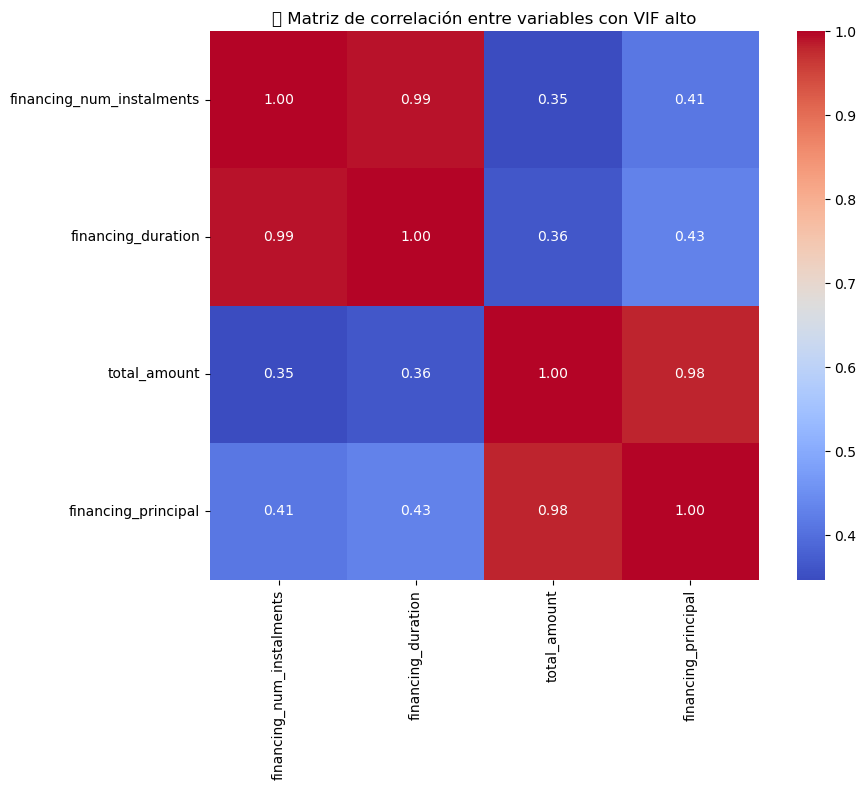

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Asumiendo que ya tienes cargado df_final
# Lista de columnas con VIF alto que quieres estudiar
cols_vif_alto = [
    'financing_num_instalments',
    'financing_duration',
    'total_amount',
    'financing_principal',
    
]

# Matriz de correlación
corr_matrix = df_final[cols_vif_alto].corr()

# Mostrar visualización
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("🔍 Matriz de correlación entre variables con VIF alto")
plt.tight_layout()
plt.show()


In [31]:
cols_to_drop = ['financing_num_instalments', 'total_amount']
df_final.drop(columns=cols_to_drop, inplace=True)


In [32]:
cols_to_drop_vif = [
    'checkout_user_agent_device_model_iPhone',  # modelo suele ser menos informativo que el sistema operativo
    'checkout_user_agent_browser_family_Mobile Safari'  # también derivado de iOS
]

df_final.drop(columns=cols_to_drop_vif, inplace=True)


### Separar en X e Y y aplicar train/test split

In [34]:
from sklearn.model_selection import train_test_split

# 1. Separar X e y
X = df_final.drop(columns=['target'])
y = df_final['target']

# 2. Hacer train-test split (80% entrenamiento, 20% test)
# Estratificamos porque target está desbalanceado
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 3. Comprobamos que todo ha ido bien
print("Distribución en y_train:\n", y_train.value_counts(normalize=True))
print("Distribución en y_test:\n", y_test.value_counts(normalize=True))
print("Shape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)
X_train

Distribución en y_train:
 target
performing     0.917680
credit_risk    0.074883
fraud_risk     0.007437
Name: proportion, dtype: float64
Distribución en y_test:
 target
performing     0.917695
credit_risk    0.074822
fraud_risk     0.007482
Name: proportion, dtype: float64
Shape X_train: (21380, 87)
Shape X_test: (5346, 87)


checkout_user_agent_is_mobile  checkout_user_agent_is_tablet   
24546                          False                          False  \
16064                           True                          False   
12352                           True                          False   
24615                           True                          False   
5537                           False                          False   
...                              ...                            ...   
17347                           True                          False   
19481                          False                          False   
18125                          False                          False   
21030                           True                          False   
13947                          False                          False   

       checkout_user_agent_is_pc  checkout_user_agent_is_touch_capable   
24546                       True                                 False  \
16064                      False                                  True   
12352                      False                                  True   
24615                      False                                  True   
5537                       False                                 False   
...                          ...                                   ...   
17347                      False                                  True   
19481                       True                                 False   
18125                       True                                 False   
21030                      False                                  True   
13947                       True                                 False   

       financing_duration  financing_downpayment_amount   
24546                 362                        159.61  \
16064                 242                         63.78   
12352                 122                         35.83   
24615                 365                          9.45   
5537                  344                         69.30   
...                   ...                           ...   
17347                 122                         29.36   
19481                  87                        121.85   
18125                 152                        107.14   
21030                 212                          8.28   
13947                 120                         25.92   

       financing_total_interest_amount  financing_annual_percentage_rate   
24546                         0.000000                          0.000005  \
16064                        39.726132                         24.500000   
12352                         6.332492                         24.500000   
24615                         0.000000                          0.000000   
5537                         27.493384                         24.500000   
...                                ...                               ...   
17347                         5.257508                         24.500000   
19481                         0.000000                          0.000000   
18125                         0.000000                          0.000000   
21030                         4.034206                         24.500000   
13947                         1.487659                         24.500000   

       financing_customer_fee_tax_rate  customer_age  ...  region_cat_samsung   
24546                              0.0            26  ...                 0.0  \
16064                             21.0            31  ...                 0.0   
12352                             21.0            38  ...                 0.0   
24615                              0.0            57  ...                 0.0   
5537                              21.0            41  ...                 0.0   
...                                ...           ...  ...                 ...   
17347                              0.0            29  ...                 0.

Tambien debo aplicar label encoder a mi variable target porque sigue en su forma categorica

In [35]:
from sklearn.preprocessing import LabelEncoder

# Creamos el codificador
le = LabelEncoder()

# Ajustamos y transformamos y_train
y_train_encoded = le.fit_transform(y_train)

# Solo transformamos y_test (no fit)
y_test_encoded = le.transform(y_test)

# Confirmamos cómo se codificaron las clases
print("Clases codificadas:", list(le.classes_))
print("Ejemplo y_train_encoded:", y_train_encoded[:5])
y_train_encoded

Clases codificadas: ['credit_risk', 'fraud_risk', 'performing']
Ejemplo y_train_encoded: [2 1 2 2 2]


array([2, 1, 2, ..., 2, 2, 2])

### Explicación

¿Qué es Target Encoding?
Target Encoding (también llamado Mean Encoding) es una técnica que convierte una variable categórica en una variable numérica continua, calculando:

- El promedio de la variable objetivo (target) para cada categoría.

Ventajas del Target Encoding
- Ideal para columnas con muchas categorías (merchant_id, device_model, etc.)

- Reduce el número de columnas

- Puede mejorar rendimiento en árboles o boosting

¿Por qué necesito usar Target Encoder en estas columnas que nos quedan?
Porque:
- Estas columnas tienen muchísimas categorías únicas (alta cardinalidad)

Si aplico OneHotEncoder:

- Se crearían cientos o miles de columnas

- El modelo puede volverse muy lento o sobreajustarse

- Y si las elimino, pierdo mucha información útil

--------------------
¿Qué opciones tengo para aplicar Target Encoding?
🔹 Opción 1: TargetEncoder con category_encoders (más simple)
- Puede introducir data leakage si no realizo el train test split de manera adecuada.

Opción 2: TargetEncoder + Cross-Validation interna (más robusto)
Se calcula la media de target usando solo los folds de entrenamiento, para evitar que el modelo “vea” los valores que está tratando de predecir. Es la opción que voy a seguir debido a que es la más robusta gracias a su manera de proceder

----------------------------
Pero ¿Qué es data leakage?
Es cuando información del futuro (test set o variable objetivo) se cuela en el entrenamiento del modelo.

El modelo aprende cosas que no debería saber aún.
→ Esto produce resultados demasiado buenos en entrenamiento, pero fracasan en producción.

Por todas estas razones y para estar seguro del procedimiento que vamos a tomar, la opción elegida es TARGETENCODING + cross validation, por su robustez.

-------------------------

¿Qué hice exactamente?
Elegí varias columnas categóricas complejas que tienen demasiados niveles (por ejemplo merchant_id, browser_version, etc.) que no era práctico codificar con One-Hot. Sino hubiese obtenido un dataframe con una cantidad de columnas muy alta.

Por ello aplico TargetEncoder con validación cruzada (K-Fold):

- Para evitar data leakage, no uso todo X_train para codificarlo a sí mismo.

Lo dividimos en 5 partes:

- Entreno el encoder con 4/5 partes.

- Transformo la 1/5 restante.

- Repito para todas las combinaciones.

- Luego codifico X_test usando un encoder entrenado en TODO X_train (porque en test sí puedes usar todo el entrenamiento).

- Finalmente, elimino las columnas originales categóricas y sustituimos por sus versiones *_te (target encoded).

## 1.7 Modelado

Hay que tener en cuenta a la hora del modelado que en este caso nos enfrentamos a un df con clases desbalanceadas entre performing, fraud risk y credit risk las cuales están codificadas de la siguiente manera: #Performing = 2, #Credit risk = 0, #fraud risk = 1. 

Por ello voy a seguir dos técnicas a la hora de hacer que estén balanceadas: SMOTE y class_weigth = 'balanced' (este ultimo presente en randomforest). La técnica será la siguiente:
- Aplicar unicamente class_weigth y observar que métricas obtenemos
- Aplicar SMOTE y class_weigth a la vez pero concretamente cuando apliquemos SMOTE lo que haremos será crear de manera sintetica esos datos de las clases desbalanceadas gracias a sampling_strategy, pero que sigan manteniendose por debajo de la clase predominante que es performing, de esta manera nos aseguramos que class_weigth siga funcionando y tener un modelo robusto. 

### PCA

c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


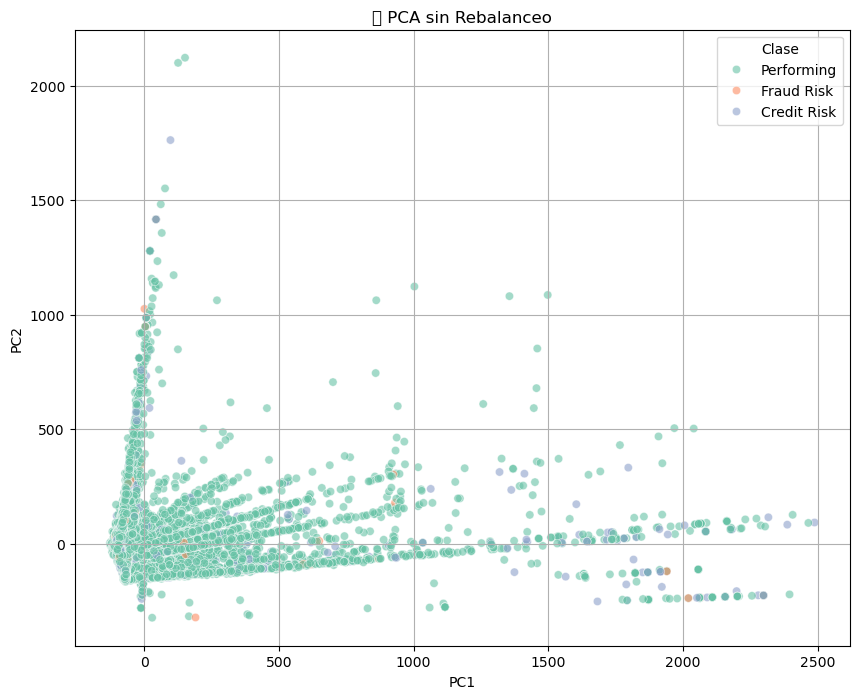

In [ ]:
# PCA sobre datos originales sin balancear
from sklearn.decomposition import PCA

pca_original = PCA(n_components=2, random_state=42)
X_pca_original = pca_original.fit_transform(X_train)

# DataFrame para graficar
df_pca_original = pd.DataFrame(X_pca_original, columns=["PC1", "PC2"])
df_pca_original["Clase"] = pd.Series(y_train_encoded).map({0: "Credit Risk", 1: "Fraud Risk", 2: "Performing"})

# Gráfico
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca_original, x="PC1", y="PC2", hue="Clase", palette="Set2", alpha=0.6)
plt.title(" PCA sin Rebalanceo")
plt.grid(True)
plt.show()


c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


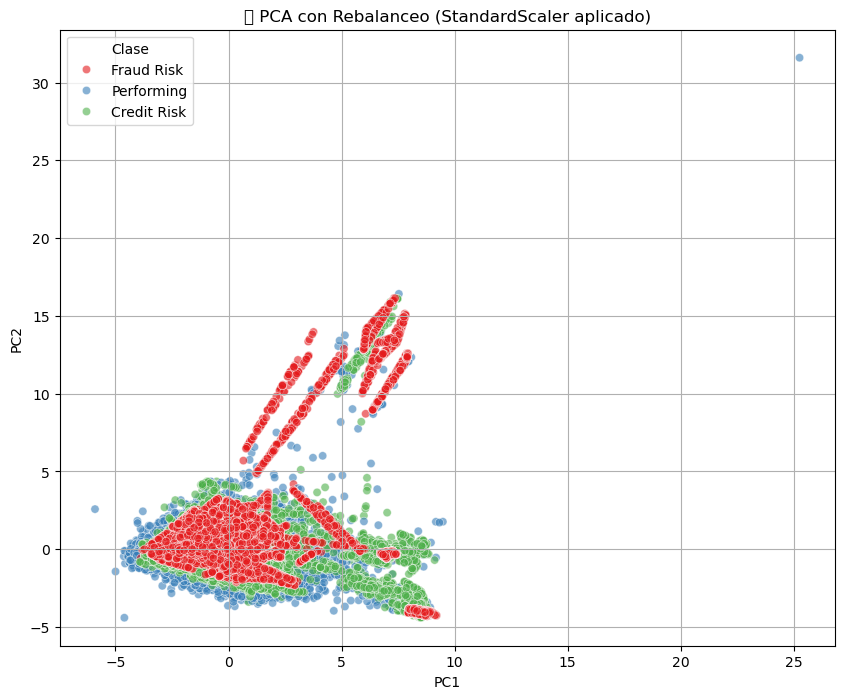

In [ ]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# 2. Copia de X_train y y_train_encoded

X_visual = X_train.copy()
y_visual = y_train_encoded.copy()


# 3. Rebalanceo SOLO para visualización

smt_vis = SMOTETomek(sampling_strategy="auto", random_state=42)
X_vis_resampled, y_vis_resampled = smt_vis.fit_resample(X_visual, y_visual)


# 4. Escalado antes del PCA
# ==============================
scaler = StandardScaler()
X_vis_scaled = scaler.fit_transform(X_vis_resampled)

# ==============================
# 5. PCA sobre los datos rebalanceados escalados

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_vis_scaled)


# 6. Crear DataFrame para graficar
# ==============================
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["Clase"] = pd.Series(y_vis_resampled).map({
    0: "Credit Risk",
    1: "Fraud Risk",
    2: "Performing"
})

# ==============================
# 7. Gráfico con seaborn

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="Clase", palette="Set1", alpha=0.6)
plt.title("PCA con Rebalanceo (StandardScaler aplicado)")
plt.grid(True)
plt.show()


c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


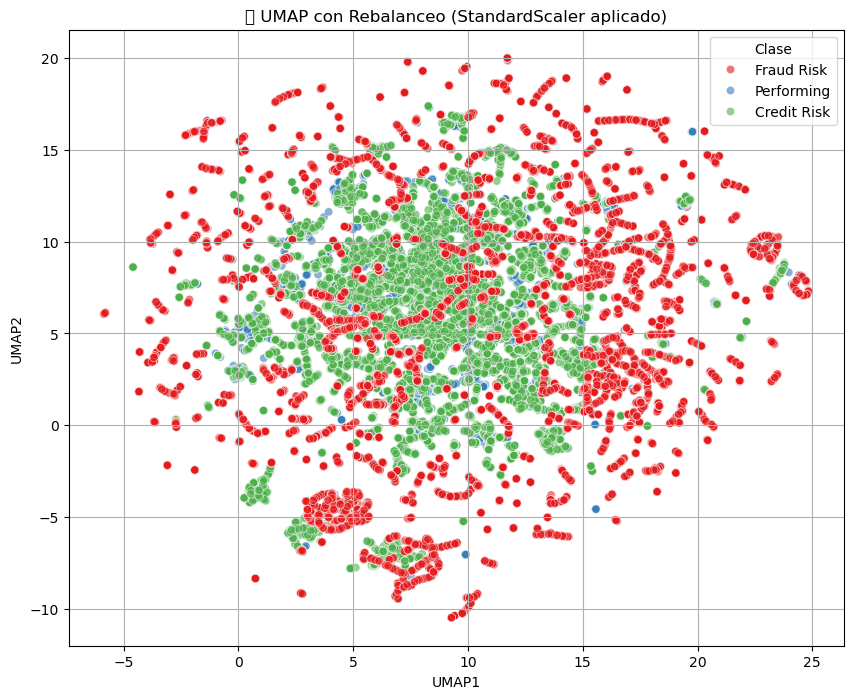

In [ ]:

from imblearn.combine import SMOTETomek
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap
import numpy as np

# 2. Copia de X_train y y_train_encoded
X_visual = X_train.copy()
y_visual = y_train_encoded.copy()

# 3. Rebalanceo SOLO para visualización
smt_vis = SMOTETomek(sampling_strategy="auto", random_state=42)
X_vis_resampled, y_vis_resampled = smt_vis.fit_resample(X_visual, y_visual)

# 4. Escalado de datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_vis_resampled)

# 5. Aplicar UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

# 6. Crear DataFrame para graficar
df_umap = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"])
df_umap["Clase"] = pd.Series(y_vis_resampled).map({
    0: "Credit Risk",
    1: "Fraud Risk",
    2: "Performing"
})

# 7. Gráfico con seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_umap, x="UMAP1", y="UMAP2", hue="Clase", palette="Set1", alpha=0.6)
plt.title("UMAP con Rebalanceo (StandardScaler aplicado)")
plt.grid(True)
plt.show()


### Clustering


#### Kmeans

c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


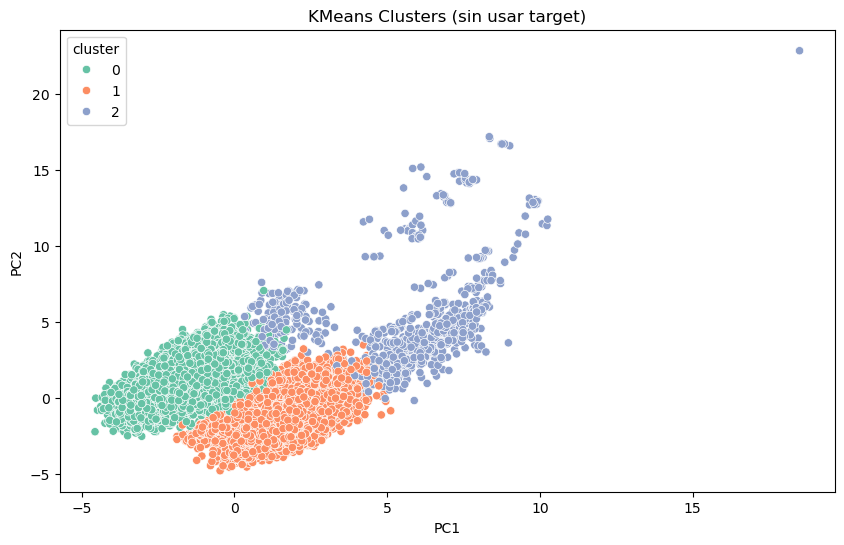

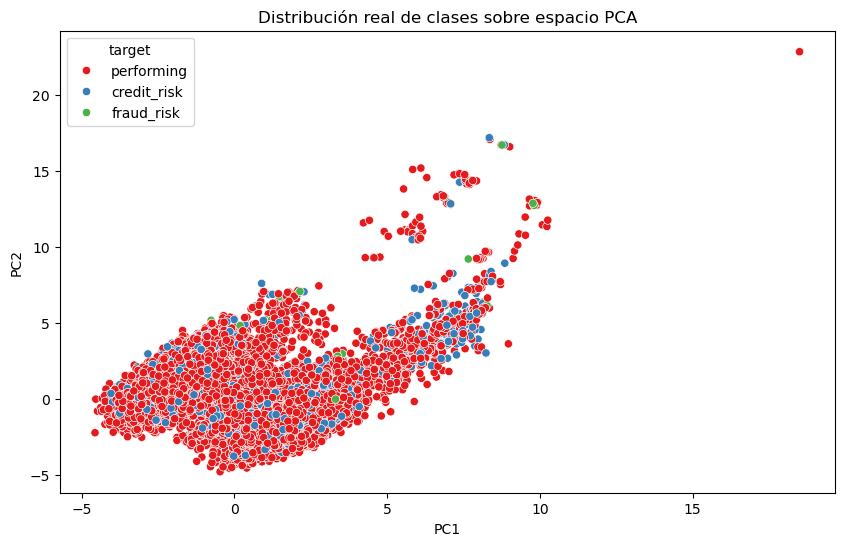

In [41]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Copiar DataFrame y separar target
df_cluster = df_final.copy()
target = df_cluster.pop('target')  # Guardamos target para comparar visualmente

# 2. Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

# 3. Aplicar KMeans con k=3 (esperamos algo parecido a Performing, Credit, Fraud)
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# 4. Añadir etiquetas al DataFrame original
df_cluster['cluster'] = cluster_labels
df_cluster['target'] = target

# 5. PCA para visualización 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_cluster['PC1'] = X_pca[:, 0]
df_cluster['PC2'] = X_pca[:, 1]

# 6. Visualizar: colores por cluster y por clase real
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cluster, x='PC1', y='PC2', hue='cluster', palette='Set2')
plt.title("KMeans Clusters (sin usar target)")
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cluster, x='PC1', y='PC2', hue='target', palette='Set1')
plt.title("Distribución real de clases sobre espacio PCA")
plt.show()


#### DBSCAN

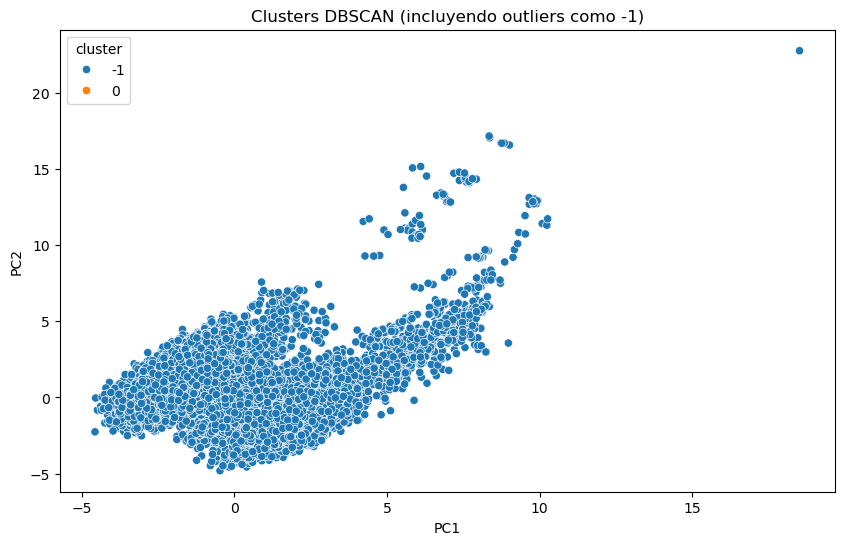

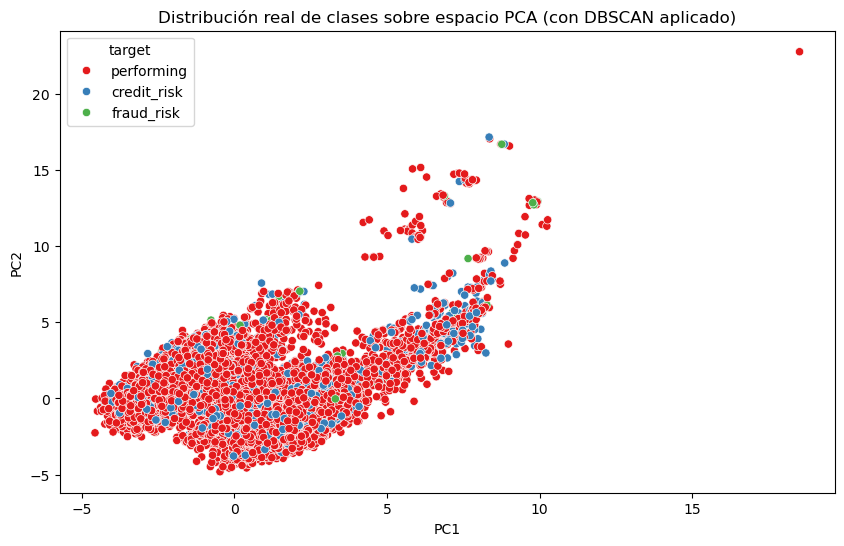

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Copiamos de nuevo el DataFrame y separamos el target
df_cluster = df_final.copy()
target = df_cluster.pop('target')

# 2. Escalamos los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

# 3. Aplicamos DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=10) 
cluster_labels = dbscan.fit_predict(X_scaled)

# 4. Agregar resultados al DataFrame
df_cluster['cluster'] = cluster_labels
df_cluster['target'] = target

# 5. PCA para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_cluster['PC1'] = X_pca[:, 0]
df_cluster['PC2'] = X_pca[:, 1]

# 6. Visualizar clusters DBSCAN
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cluster, x='PC1', y='PC2', hue='cluster', palette='tab10', legend='full')
plt.title("Clusters DBSCAN (incluyendo outliers como -1)")
plt.show()

# 7. Visualizar clases reales
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cluster, x='PC1', y='PC2', hue='target', palette='Set1')
plt.title("Distribución real de clases sobre espacio PCA (con DBSCAN aplicado)")
plt.show()


### Regresión logística

#### Nuevo intento

Reporte de clasificación - Logistic Regression:

              precision    recall  f1-score   support

 credit_risk       0.12      0.38      0.18       400
  fraud_risk       0.02      0.55      0.04        40
  performing       0.95      0.60      0.74      4906

    accuracy                           0.58      5346
   macro avg       0.37      0.51      0.32      5346
weighted avg       0.89      0.58      0.69      5346



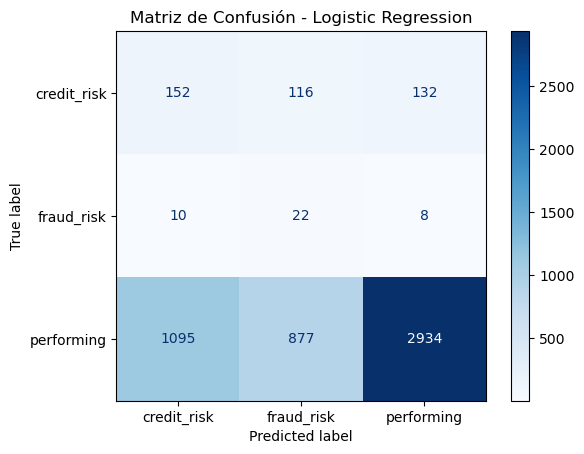

Matriz de confusión (cruda):
 [[ 152  116  132]
 [  10   22    8]
 [1095  877 2934]]


In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# 1. Escalado de X solo para este modelo
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Entrenar modelo
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_model.fit(X_train_scaled, y_train_encoded)

# 3. Predicción
y_pred_lr1 = lr_model.predict(X_test_scaled)

# 4. Reporte de clasificación
print("Reporte de clasificación - Logistic Regression:\n")
print(classification_report(y_test_encoded, y_pred_lr1, target_names=le.classes_))

# 5. Matriz de confusión
cm = confusion_matrix(y_test_encoded, y_pred_lr1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión - Logistic Regression')
plt.show()
# 5. Matriz de confusión
cm = confusion_matrix(y_test_encoded, y_pred_lr1)

# Mostramos sin graficar
print("Matriz de confusión (cruda):\n", cm)



Matriz de confusión (normal):
[[ 163  104  133]
 [   9   21   10]
 [1159  800 2947]]


c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


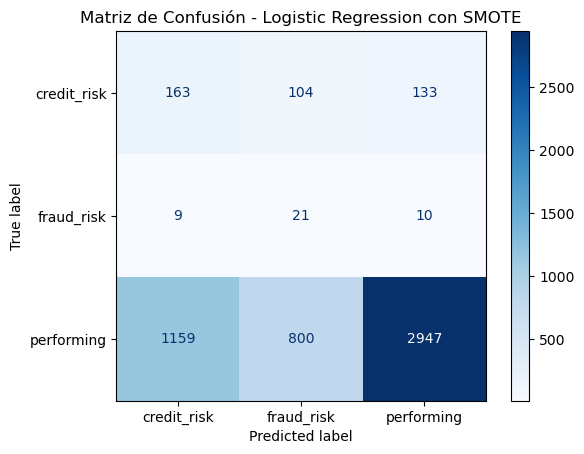

Reporte de clasificación:
              precision    recall  f1-score   support

 credit_risk       0.12      0.41      0.19       400
  fraud_risk       0.02      0.53      0.04        40
  performing       0.95      0.60      0.74      4906

    accuracy                           0.59      5346
   macro avg       0.37      0.51      0.32      5346
weighted avg       0.88      0.59      0.69      5346



In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# 1. Escalar los datos (es importante antes de SMOTE y para LogisticRegression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Aplicar SMOTE al conjunto de entrenamiento
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train_scaled, y_train_encoded)

# 3. Entrenar modelo LogisticRegression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_smote, y_train_smote)

# 4. Predecir
y_pred_lr2 = model.predict(X_test_scaled)

# 5. Matriz de confusión
cm = confusion_matrix(y_test_encoded, y_pred_lr2)
print("Matriz de confusión (normal):")
print(cm)

# 6. Mostrar gráfica
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión - Logistic Regression con SMOTE")
plt.show()

# 7. Reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(y_test_encoded, y_pred_lr2, target_names=le.classes_))


Reporte de clasificación (class_weight personalizado):
              precision    recall  f1-score   support

 credit_risk       0.14      0.36      0.20       400
  fraud_risk       0.03      0.47      0.05        40
  performing       0.95      0.70      0.81      4906

    accuracy                           0.67      5346
   macro avg       0.37      0.51      0.35      5346
weighted avg       0.88      0.67      0.76      5346

Matriz de confusión:
[[ 145   88  167]
 [  10   19   11]
 [ 869  602 3435]]


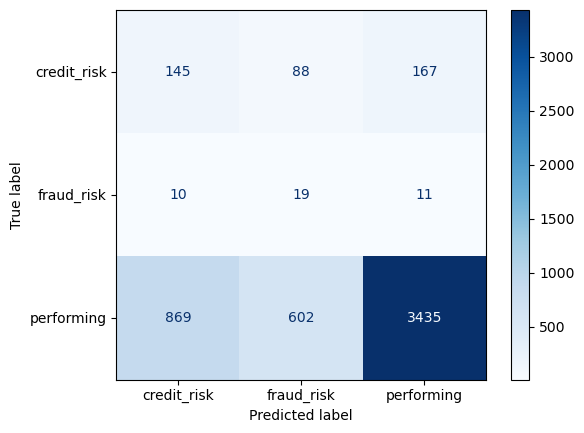

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Definir pesos personalizados
class_weights = {
    0: 10,   # credit_risk
    1: 80,   # fraud_risk
    2: 1     # performing
}

# 3. Entrenar modelo con class_weight personalizado
model = LogisticRegression(class_weight=class_weights, max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train_encoded)

# 4. Predicciones
y_pred_lr3 = model.predict(X_test_scaled)

# 5. Reporte
print("Reporte de clasificación (class_weight personalizado):")
print(classification_report(y_test_encoded, y_pred_lr3, target_names=le.classes_))

# 6. Matriz de confusión numérica
cm = confusion_matrix(y_test_encoded, y_pred_lr3)
print("Matriz de confusión:")
print(cm)

# 7. Matriz de confusión gráfica
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')


### Random Forest

#### Nuevo intento

📉 Distribución tras undersampling: Counter({2: 3000, 0: 1601, 1: 159})
📈 Distribución tras SMOTE+Tomek: Counter({2: 2598, 1: 1771, 0: 1401})
Fitting 5 folds for each of 1 candidates, totalling 5 fits
✅ Mejores parámetros encontrados: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

📊 Matriz de confusión:
[[  73  144  183]
 [   9   23    8]
 [ 396 1183 3327]]

📄 Reporte de clasificación:
              precision    recall  f1-score   support

 credit_risk       0.15      0.18      0.17       400
  fraud_risk       0.02      0.57      0.03        40
  performing       0.95      0.68      0.79      4906

    accuracy                           0.64      5346
   macro avg       0.37      0.48      0.33      5346
weighted avg       0.88      0.64      0.74      5346



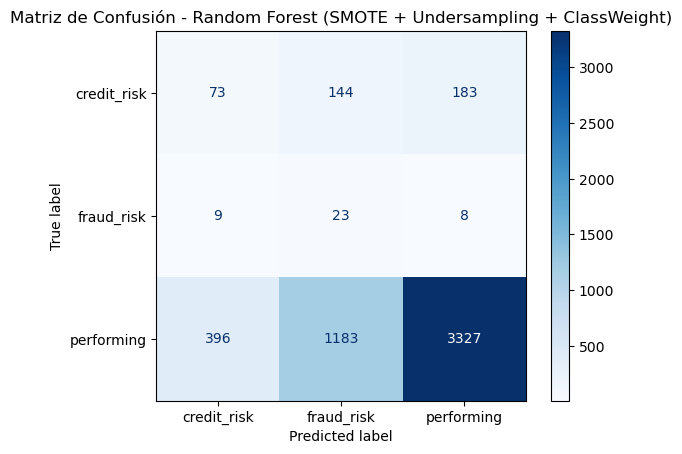

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from collections import Counter

# 1. Undersampling para reducir clase mayoritaria (2: performing)
rus = RandomUnderSampler(sampling_strategy={2: 3000}, random_state=42)
X_down, y_down = rus.fit_resample(X_train, y_train_encoded)
print(" Distribución tras undersampling:", Counter(y_down))

# 2. SMOTETomek para oversampling + limpieza
smt = SMOTETomek(sampling_strategy={0: 1800, 1: 1800}, random_state=42)
X_train_resampled, y_train_resampled = smt.fit_resample(X_down, y_down)
print(" Distribución tras SMOTE+Tomek:", Counter(y_train_resampled))

# 3. class_weight personalizado 
custom_class_weight = {
    0: 10,  # Credit Risk
    1: 40,  # Fraud Risk
    2: 5    # Performing (menos porque ya tiene menos presencia)
}

# 4. Definir modelo y grid
rf = RandomForestClassifier(
    class_weight=custom_class_weight,
    random_state=42,
    n_jobs=-1
)

param_grid = {
    'n_estimators': [200],
    'max_depth': [10],
    'min_samples_split': [5]
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='recall_macro',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# 5. Entrenar el modelo
grid_search.fit(X_train_resampled, y_train_resampled)

# 6. Predecir y evaluar
y_pred_rf1 = grid_search.predict(X_test)

print(" Mejores parámetros encontrados:", grid_search.best_params_)
print("\n Matriz de confusión:")
print(confusion_matrix(y_test_encoded, y_pred_rf1))
print("\n Reporte de clasificación:")
print(classification_report(y_test_encoded, y_pred_rf1, target_names=le.classes_))

# 7. Matriz de confusión visual
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test_encoded, display_labels=le.classes_, cmap="Blues")
plt.title("Matriz de Confusión - Random Forest (SMOTE + Undersampling + ClassWeight)")
plt.show()


📉 Después de undersampling: Counter({2: 19000, 0: 1601, 1: 159})
📈 Después de GAN-like augmentation (train): Counter({0: 20601, 1: 19159, 2: 19000})
📊 Después de GAN-like augmentation (val): Counter({2: 4906, 0: 4100, 1: 3040})
✅ Mejores parámetros: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

📊 Matriz de Confusión:
[[2525 1005  570]
 [1426 1395  219]
 [2672  752 1482]]

📄 Reporte de Clasificación:
              precision    recall  f1-score   support

 credit_risk       0.38      0.62      0.47      4100
  fraud_risk       0.44      0.46      0.45      3040
  performing       0.65      0.30      0.41      4906

    accuracy                           0.45     12046
   macro avg       0.49      0.46      0.44     12046
weighted avg       0.51      0.45      0.44     12046



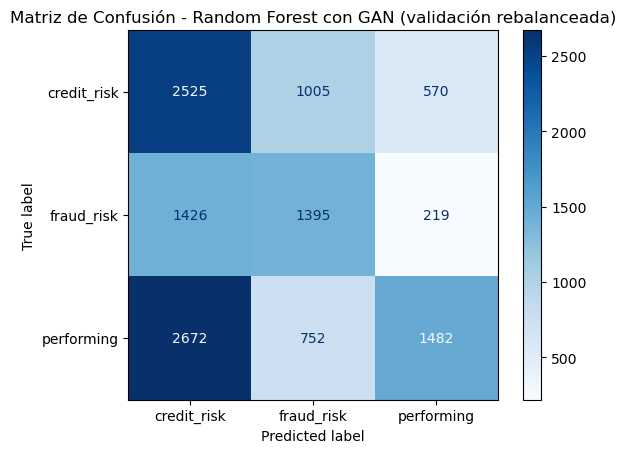

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter

# FUNCIONES AUXILIARES

def generate_synthetic_data(X_real, y_real, target_class, n_samples):
    """
    Simula generación de datos sintéticos para una clase específica (como haría un GAN).
    """
    X_class = X_real[y_real == target_class]
    X_syn = resample(X_class, replace=True, n_samples=n_samples, random_state=42)
    y_syn = np.array([target_class] * n_samples)
    return X_syn, y_syn

#  DATOS REALES DE PARTIDA: X_train, y_train_encoded, X_test, y_test_encoded

# 1. Undersampling de clase 2 (performing)
rus = RandomUnderSampler(sampling_strategy={2: 19000}, random_state=42)
X_down, y_down = rus.fit_resample(X_train, y_train_encoded)
print(" Después de undersampling:", Counter(y_down))

# 2. Data augmentation sintético para clases 0 y 1 (simulación GAN)
X_syn_0, y_syn_0 = generate_synthetic_data(X_down, y_down, target_class=0, n_samples=19000)
X_syn_1, y_syn_1 = generate_synthetic_data(X_down, y_down, target_class=1, n_samples=19000)

X_train_aug = pd.concat([X_down, X_syn_0, X_syn_1], axis=0)
y_train_aug = np.concatenate([y_down, y_syn_0, y_syn_1])
print(" Después de GAN-like augmentation (train):", Counter(y_train_aug))

# 3. Augmentamos también el test SOLO para validación
X_val = X_test.copy()
y_val = y_test_encoded.copy()

X_val_0, y_val_0 = generate_synthetic_data(X_val, y_val, target_class=0, n_samples=3700)
X_val_1, y_val_1 = generate_synthetic_data(X_val, y_val, target_class=1, n_samples=3000)

X_val_aug = pd.concat([X_val, X_val_0, X_val_1], axis=0)
y_val_aug = np.concatenate([y_val, y_val_0, y_val_1])
print(" Después de GAN-like augmentation (val):", Counter(y_val_aug))

# 4. Modelo con class_weight
custom_weights = {0: 100, 1: 200, 2: 45}

rf = RandomForestClassifier(class_weight= custom_weights, random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators': [200],
    'max_depth': [10],
    'min_samples_split': [5]
}

grid = GridSearchCV(rf, param_grid, scoring='recall_macro', cv=5, n_jobs=-1)
grid.fit(X_train_aug, y_train_aug)

# 5. Evaluación
y_pred = grid.predict(X_val_aug)

print(" Mejores parámetros:", grid.best_params_)
print("\n Matriz de Confusión:")
print(confusion_matrix(y_val_aug, y_pred))
print("\n Reporte de Clasificación:")
print(classification_report(y_val_aug, y_pred, target_names=le.classes_))

ConfusionMatrixDisplay.from_estimator(grid.best_estimator_, X_val_aug, y_val_aug, display_labels=le.classes_, cmap="Blues")
plt.title("Matriz de Confusión - Random Forest con GAN (validación rebalanceada)")
plt.show()


📉 Distribución tras undersampling: Counter({2: 14000, 0: 1601, 1: 159})
📈 Distribución tras SMOTE+Tomek: Counter({1: 13985, 2: 13883, 0: 13880})
Fitting 5 folds for each of 1 candidates, totalling 5 fits
✅ Mejores parámetros encontrados: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}

📊 Matriz de confusión:
[[ 165  196   39]
 [   7   32    1]
 [1861 1836 1209]]

📄 Reporte de clasificación:
              precision    recall  f1-score   support

 credit_risk       0.08      0.41      0.14       400
  fraud_risk       0.02      0.80      0.03        40
  performing       0.97      0.25      0.39      4906

    accuracy                           0.26      5346
   macro avg       0.35      0.49      0.19      5346
weighted avg       0.89      0.26      0.37      5346



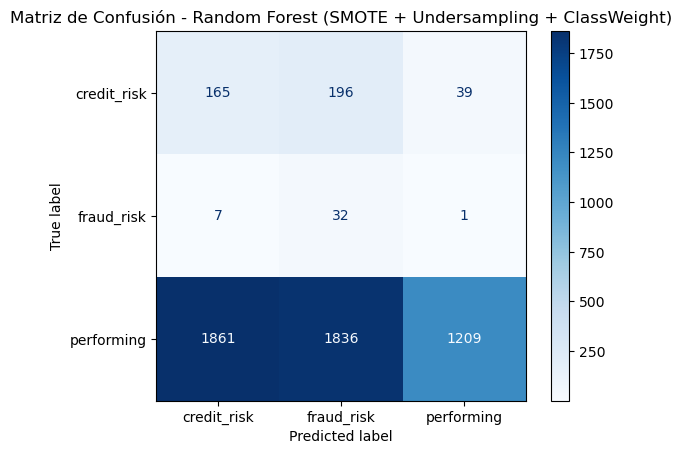

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from collections import Counter

# 1. Undersampling para reducir clase mayoritaria (2: performing)
rus = RandomUnderSampler(sampling_strategy={2: 14000}, random_state=42)
X_down, y_down = rus.fit_resample(X_train, y_train_encoded)
print(" Distribución tras undersampling:", Counter(y_down))

# 2. SMOTETomek para oversampling + limpieza
smt = SMOTETomek(sampling_strategy={0: 14000, 1: 14000}, random_state=42)
X_train_resampled, y_train_resampled = smt.fit_resample(X_down, y_down)
print(" Distribución tras SMOTE+Tomek:", Counter(y_train_resampled))

# 3. class_weight personalizado
custom_class_weight = {
    0: 10,  # Credit Risk
    1: 40,  # Fraud Risk
    2: 2    # Performing
}

# 4. Definir modelo
rf = RandomForestClassifier(
    class_weight=custom_class_weight,
    random_state=42,
    n_jobs=-1
)

# 5. Definir grid y StratifiedKFold
param_grid = {
    'n_estimators': [200],
    'max_depth': [10],
    'min_samples_split': [5]
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='recall_macro',
    cv=cv_strategy,
    verbose=2,
    n_jobs=-1
)

# 6. Entrenar modelo
grid_search.fit(X_train_resampled, y_train_resampled)

# 7. Predecir y evaluar
y_pred_rf2 = grid_search.predict(X_test)

print(" Mejores parámetros encontrados:", grid_search.best_params_)
print("\n Matriz de confusión:")
print(confusion_matrix(y_test_encoded, y_pred_rf2)) 
print("\n Reporte de clasificación:")
print(classification_report(y_test_encoded, y_pred_rf2, target_names=le.classes_))

# 8. Matriz de confusión visual
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_,
    X_test,
    y_test_encoded,
    display_labels=le.classes_,
    cmap="Blues"
)
plt.title("Matriz de Confusión - Random Forest (SMOTE + Undersampling+ oversampling + ClassWeight)")
plt.show()



📊 Matriz de confusión (con triple umbral):
[[  94  288   18]
 [   5   34    1]
 [1374 2947  585]]

📄 Reporte de clasificación (con triple umbral):
              precision    recall  f1-score   support

 credit_risk       0.06      0.23      0.10       400
  fraud_risk       0.01      0.85      0.02        40
  performing       0.97      0.12      0.21      4906

    accuracy                           0.13      5346
   macro avg       0.35      0.40      0.11      5346
weighted avg       0.89      0.13      0.20      5346



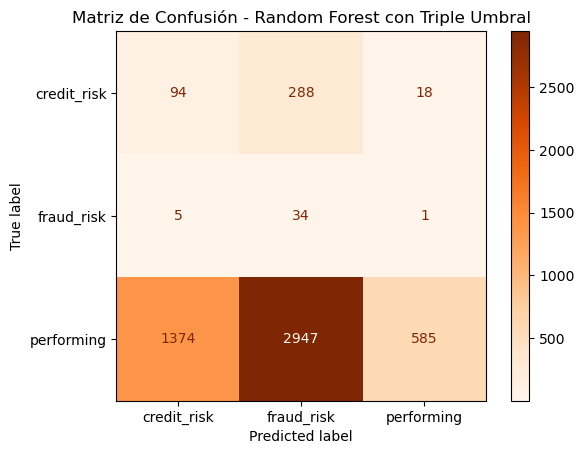

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Obtener las probabilidades del modelo ajustado
y_proba = grid_search.predict_proba(X_test)

# Índices de clase (ajustar si cambia el orden)
idx_credit = list(le.classes_).index('credit_risk')
idx_fraud = list(le.classes_).index('fraud_risk')
idx_performing = list(le.classes_).index('performing')

# Definir umbrales por clase
threshold_credit = 0.4
threshold_fraud = 0.2
threshold_performing = 0.7

# Aplicar reglas de decisión basadas en probabilidades
y_pred_adjusted_rf = []

for probs in y_proba:
    if probs[idx_fraud] >= threshold_fraud:
        y_pred_adjusted_rf.append(idx_fraud)
    elif probs[idx_credit] >= threshold_credit:
        y_pred_adjusted_rf.append(idx_credit)
    elif probs[idx_performing] >= threshold_performing:
        y_pred_adjusted_rf.append(idx_performing)
    else:
        # Fallback: asignar clase con mayor probabilidad
        y_pred_adjusted_rf.append(np.argmax(probs))

# Evaluar resultados
print("\n Matriz de confusión (con triple umbral):")
print(confusion_matrix(y_test_encoded, y_pred_adjusted_rf))
print("\n Reporte de clasificación (con triple umbral):")
print(classification_report(y_test_encoded, y_pred_adjusted_rf, target_names=le.classes_))

# Mostrar matriz de confusión visualmente
ConfusionMatrixDisplay.from_predictions(
    y_test_encoded,
    y_pred_adjusted_rf,
    display_labels=le.classes_,
    cmap="Oranges"
)
plt.title("Matriz de Confusión - Random Forest con Triple Umbral")
plt.show()


C:\Users\kevin.vargas\AppData\Local\Temp\ipykernel_20872\1505608289.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df.head(15), x='Importance', y='Feature', palette='viridis')
C:\Users\kevin.vargas\AppData\Local\Temp\ipykernel_20872\1505608289.py:21: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


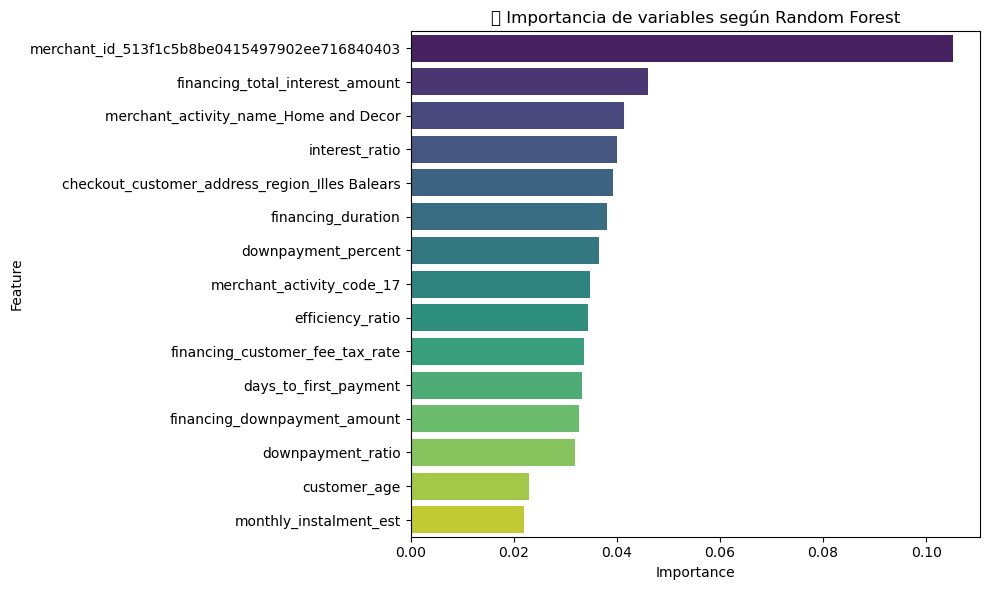

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener el mejor modelo del GridSearch
best_rf = grid_search.best_estimator_

# Extraer importancias
importances = best_rf.feature_importances_

# Crear dataframe con nombres y orden
feature_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Mostrar top 15
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title(' Importancia de variables según Random Forest')
plt.tight_layout()
plt.show()


100%|===================| 16004/16038 [06:26<00:00]        

🔍 Variables que más impulsan la predicción de fraude:


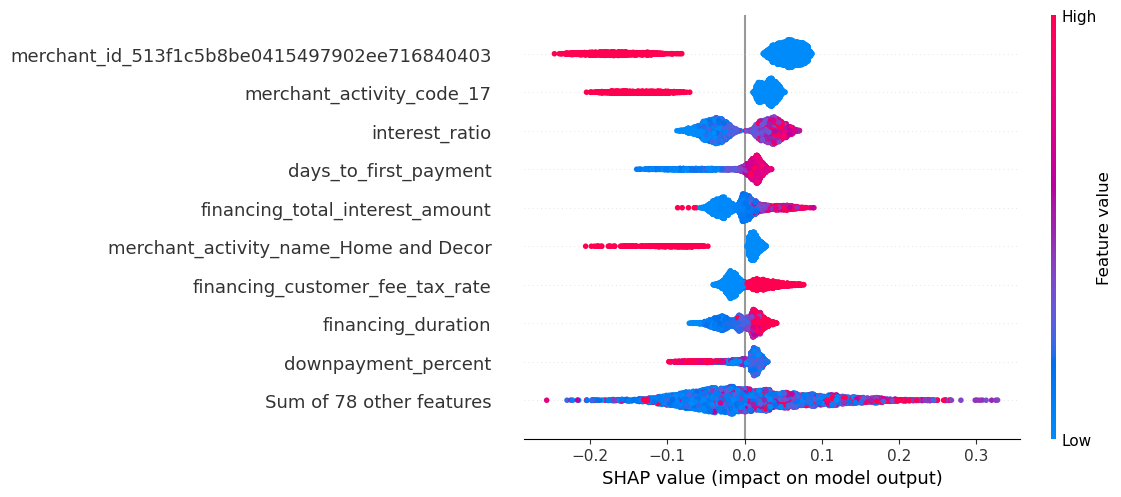

In [ ]:
import shap
import pandas as pd

# 1. Asegurarse de que X_test es numérico (float)
X_test_float = X_test.astype(float)

# 2. Obtener el mejor modelo
model = grid_search.best_estimator_

# 3. Inicializar el explainer SHAP
explainer = shap.Explainer(model, X_test_float)
shap_values = explainer(X_test_float)

# 4. Gráfico resumen: impacto global de cada variable en predicción de FRAUDE (clase 1)
print(" Variables que más impulsan la predicción de fraude:")
shap.plots.beeswarm(shap_values[..., 1])  # clase 1 = fraud_risk



In [ ]:
import numpy as np

# Cálculo de importancia media absoluta para clase 1 (fraud)
mean_abs_shap = np.abs(shap_values[..., 1].values).mean(axis=0)
shap_summary = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean |SHAP value|': mean_abs_shap
}).sort_values(by='Mean |SHAP value|', ascending=False)

print("\n Top 15 variables más influyentes para detectar fraude:")
display(shap_summary.head(15))



📊 Top 15 variables más influyentes para detectar fraude:


Feature  Mean |SHAP value|
16    merchant_id_513f1c5b8be0415497902ee716840403           0.080947
35                       merchant_activity_code_17           0.051757
70                                  interest_ratio           0.038247
10                           days_to_first_payment           0.022483
6                  financing_total_interest_amount           0.022308
25           merchant_activity_name_Home and Decor           0.021970
8                  financing_customer_fee_tax_rate           0.021249
4                               financing_duration           0.020041
74                             downpayment_percent           0.018410
5                     financing_downpayment_amount           0.015122
7                 financing_annual_percentage_rate           0.013930
11                                   created_month           0.013660
27      merchant_activity_name_Moda y Complementos           0.012801
64  checkout_customer_address_region_Illes Balears           0.012329
71                               downpayment_ratio           0.011208

### XGBOOST

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, fbeta_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier
from collections import Counter

# --- Paso 1: Selección de las 25 mejores features ---
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_selector.fit(X_train, y_train_encoded)

importances = rf_selector.feature_importances_
features_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
features_df = features_df.sort_values(by='Importance', ascending=False)
top_25_features = features_df.head(25)['Feature'].tolist()

X_train_top = X_train[top_25_features]
X_test_top = X_test[top_25_features]

# --- Paso 2: Undersampling (Reducimos Performing) ---
rus = RandomUnderSampler(sampling_strategy={2: 3000}, random_state=42)
X_down, y_down = rus.fit_resample(X_train_top, y_train_encoded)
print("Distribución tras undersampling:", Counter(y_down))

# --- Paso 3: SMOTE + Tomek para ampliar riesgos y limpiar ---
smt = SMOTETomek(sampling_strategy={0: 3600, 1: 5900}, random_state=42)
X_resampled, y_resampled = smt.fit_resample(X_down, y_down)
print(" Distribución tras SMOTE+Tomek:", Counter(y_resampled))

# --- Paso 4: Calcular sample_weight ---
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_resampled), y=y_resampled)
scale_weights = dict(zip(np.unique(y_resampled), class_weights))
print(" sample_weight por clase:", scale_weights)

sample_weights = np.array([scale_weights[label] for label in y_resampled])

# --- Paso 5: Definir modelo y parámetros ---
xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 10],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Scoring personalizado: F2 macro (más énfasis en recall)
f2_scorer = make_scorer(fbeta_score, beta=2, average='macro')

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring=f2_scorer,
    cv=3,
    n_jobs=-1,
    verbose=2
)

# --- Paso 6: Entrenar ---
grid_search.fit(X_resampled, y_resampled, sample_weight=sample_weights)

# --- Paso 7: Evaluar ---
y_pred_xg1 = grid_search.predict(X_test_top)

print(" Mejores parámetros encontrados:", grid_search.best_params_)
print(" Matriz de confusión:\n", confusion_matrix(y_test_encoded, y_pred_xg1))
print("\n Reporte de clasificación:\n", classification_report(
    y_test_encoded, y_pred_xg1,
    target_names=['Credit Risk', 'Fraud Risk', 'Performing']
))


📉 Distribución tras undersampling: Counter({2: 3000, 0: 1601, 1: 159})
📈 Distribución tras SMOTE+Tomek: Counter({1: 5882, 0: 3409, 2: 2815})
⚖️ sample_weight por clase: {0: 1.183729343893615, 1: 0.6860478295364388, 2: 1.4335109532267614}
Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\xgboost\core.py:158: UserWarning: [14:09:58] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Mejores parámetros encontrados: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
📊 Matriz de confusión:
 [[ 133    9  258]
 [  19    1   20]
 [ 802   48 4056]]

📄 Reporte de clasificación:
               precision    recall  f1-score   support

 Credit Risk       0.14      0.33      0.20       400
  Fraud Risk       0.02      0.03      0.02        40
  Performing       0.94      0.83      0.88      4906

    accuracy                           0.78      5346
   macro avg       0.36      0.39      0.36      5346
weighted avg       0.87      0.78      0.82      5346



In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

# --- Paso 1: Selección de las mejores features (top 25 ya entrenado)
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_selector.fit(X_train, y_train_encoded)

importances = rf_selector.feature_importances_
top_25_features = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances}) \
                    .sort_values(by='Importance', ascending=False) \
                    .head(25)['Feature'].tolist()

X_train_top = X_train[top_25_features]
X_test_top = X_test[top_25_features]

# --- Paso 2: Rebalanceo (undersampling + SMOTETomek)
rus = RandomUnderSampler(sampling_strategy={2: 8000}, random_state=42)
X_down, y_down = rus.fit_resample(X_train_top, y_train_encoded)

smt = SMOTETomek(sampling_strategy={0: 13600, 1: 15900}, random_state=42)
X_resampled, y_resampled = smt.fit_resample(X_down, y_down)

print(" Distribución final:", Counter(y_resampled))

# --- Paso 3: Calcular sample_weights y scale_pos_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_resampled), y=y_resampled)
scale_weights = dict(zip(np.unique(y_resampled), class_weights))
sample_weights = np.array([scale_weights[label] for label in y_resampled])

# Solo como referencia (para binarias funciona directo)
n_total = len(y_resampled)
counts = Counter(y_resampled)
scale_pos_weight_0 = n_total / (3 * counts[0])
scale_pos_weight_1 = n_total / (3 * counts[1])
scale_pos_weight_2 = n_total / (3 * counts[2])
print(" scale_pos_weight (referencia):", {
    0: round(scale_pos_weight_0, 2),
    1: round(scale_pos_weight_1, 2),
    2: round(scale_pos_weight_2, 2)
})

# --- Paso 4: Entrenar modelo (sin early stopping)
model = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight_0,  # solo se usa en binaria, pero mantenemos por consistencia
    max_depth=8,
    learning_rate=0.1,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)

model.fit(
    X_resampled, y_resampled,
    sample_weight=sample_weights,
    verbose=True
)

# --- Paso 5: Evaluar
y_pred_xg2 = model.predict(X_test_top)

print(" Matriz de confusión:\n", confusion_matrix(y_test_encoded, y_pred_xg2))
print("\n Reporte de clasificación:\n", classification_report(
    y_test_encoded, y_pred_xg2,
    target_names=['Credit Risk', 'Fraud Risk', 'Performing']
))


📊 Distribución final: Counter({1: 15882, 0: 13497, 2: 7907})
⚖️ scale_pos_weight (referencia): {0: 0.92, 1: 0.78, 2: 1.57}


c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\xgboost\core.py:158: UserWarning: [14:10:10] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 Matriz de confusión:
 [[  59    4  337]
 [   7    1   32]
 [ 194   19 4693]]

📄 Reporte de clasificación:
               precision    recall  f1-score   support

 Credit Risk       0.23      0.15      0.18       400
  Fraud Risk       0.04      0.03      0.03        40
  Performing       0.93      0.96      0.94      4906

    accuracy                           0.89      5346
   macro avg       0.40      0.38      0.38      5346
weighted avg       0.87      0.89      0.88      5346



In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

# --- Paso 1: Selección de las mejores features (top 25 ya entrenado)
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_selector.fit(X_train, y_train_encoded)

importances = rf_selector.feature_importances_
top_25_features = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances}) \
                    .sort_values(by='Importance', ascending=False) \
                    .head(25)['Feature'].tolist()

X_train_top = X_train[top_25_features]
X_test_top = X_test[top_25_features]

# --- Paso 2: Rebalanceo (undersampling + SMOTETomek)
rus = RandomUnderSampler(sampling_strategy={2: 14000}, random_state=42)
X_down, y_down = rus.fit_resample(X_train_top, y_train_encoded)

smt = SMOTETomek(sampling_strategy={0: 14000, 1: 14000}, random_state=42)
X_resampled, y_resampled = smt.fit_resample(X_down, y_down)

print(" Distribución final:", Counter(y_resampled))

# --- Paso 3: Aplicar tus pesos personalizados
# Clase 0 = Credit Risk → peso 10
# Clase 1 = Fraud Risk  → peso 40
# Clase 2 = Performing  → peso 1

custom_weights = {0: 10, 1: 900, 2: 0.08}

# Crear sample_weights para cada muestra en y_resampled
sample_weights = np.array([custom_weights[label] for label in y_resampled])

# --- Paso 4: Entrenar modelo (XGBoost multiclase con sample_weight)
model = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    max_depth=8,
    learning_rate=0.1,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)

model.fit(
    X_resampled, y_resampled,
    sample_weight=sample_weights,
    verbose=True
)

# --- Paso 5: Evaluar
y_pred_xg3 = model.predict(X_test_top)

print(" Matriz de confusión:\n", confusion_matrix(y_test_encoded, y_pred_xg3))
print("\n Reporte de clasificación:\n", classification_report(
    y_test_encoded, y_pred_xg3,
    target_names=['Credit Risk', 'Fraud Risk', 'Performing']
))


📊 Distribución final: Counter({1: 13985, 2: 13868, 0: 13865})


c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\xgboost\core.py:158: UserWarning: [14:10:25] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 Matriz de confusión:
 [[ 205   19  176]
 [  26    7    7]
 [1876  188 2842]]

📄 Reporte de clasificación:
               precision    recall  f1-score   support

 Credit Risk       0.10      0.51      0.16       400
  Fraud Risk       0.03      0.17      0.06        40
  Performing       0.94      0.58      0.72      4906

    accuracy                           0.57      5346
   macro avg       0.36      0.42      0.31      5346
weighted avg       0.87      0.57      0.67      5346



In [52]:
y_proba = model.predict_proba(X_test_top)
threshold_credit = 0.3
threshold_fraud = 0.005
threshold_performing = 0.8

idx_credit = list(le.classes_).index('credit_risk')
idx_fraud = list(le.classes_).index('fraud_risk')
idx_performing = list(le.classes_).index('performing')

y_pred_adjusted = []

for probs in y_proba:
    if probs[idx_fraud] >= threshold_fraud:
        y_pred_adjusted.append(idx_fraud)
    elif probs[idx_credit] >= threshold_credit:
        y_pred_adjusted.append(idx_credit)
    elif probs[idx_performing] >= threshold_performing:
        y_pred_adjusted.append(idx_performing)
    else:
        # Fallback: asignar la clase con mayor probabilidad
        y_pred_adjusted.append(np.argmax(probs))

from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test_encoded, y_pred_adjusted))
print(classification_report(y_test_encoded, y_pred_adjusted, target_names=le.classes_))


[[ 192  106  102]
 [  20   18    2]
 [1940  868 2098]]
              precision    recall  f1-score   support

 credit_risk       0.09      0.48      0.15       400
  fraud_risk       0.02      0.45      0.03        40
  performing       0.95      0.43      0.59      4906

    accuracy                           0.43      5346
   macro avg       0.35      0.45      0.26      5346
weighted avg       0.88      0.43      0.55      5346



### LightGBM

In [ ]:
from lightgbm import LGBMClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import numpy as np

# --- Paso 1: Undersampling clase mayoritaria (Performing - clase 2) ---
rus = RandomUnderSampler(sampling_strategy={2: 15000}, random_state=42)
X_down, y_down = rus.fit_resample(X_train, y_train_encoded)
print(" Distribución tras undersampling:", Counter(y_down))

# --- Paso 2: SMOTETomek para clases minoritarias ---
smt = SMOTETomek(sampling_strategy={0: 13000, 1: 10000}, random_state=42)
X_resampled, y_resampled = smt.fit_resample(X_down, y_down)
print(" Distribución tras SMOTE+Tomek:", Counter(y_resampled))

# --- Paso 3: Calcular pesos por clase ---
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_resampled),
                                     y=y_resampled)
weight_dict = dict(zip(np.unique(y_resampled), class_weights))
print(" sample_weight por clase:", weight_dict)

# --- Paso 4: Asignar peso por fila ---
sample_weights = np.array([weight_dict[label] for label in y_resampled])

# --- Paso 5: Definir modelo LGBM ---
lgbm = LGBMClassifier(
    objective='multiclass',
    num_class=3,
    random_state=42,
    n_jobs=-1
)

# --- Paso 6: GridSearch para hiperparámetros ---
param_grid = {
    'n_estimators': [200],
    'max_depth': [10],
    'learning_rate': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [1.0]
}

grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='recall_macro',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# --- Paso 7: Entrenar con pesos personalizados ---
grid_search.fit(X_resampled, y_resampled, sample_weight=sample_weights)

# --- Paso 8: Evaluación sobre test ---
y_pred = grid_search.predict(X_test)

print(" Mejores parámetros encontrados:", grid_search.best_params_)
print(" Matriz de confusión:\n", confusion_matrix(y_test_encoded, y_pred))
print("\n Reporte de clasificación:\n", classification_report(
    y_test_encoded, y_pred,
    target_names=['Credit Risk', 'Fraud Risk', 'Performing']
))


📉 Distribución tras undersampling: Counter({2: 15000, 0: 1601, 1: 159})
📈 Distribución tras SMOTE+Tomek: Counter({2: 14856, 0: 12855, 1: 9989})
⚖️ sample_weight por clase: {0: 0.9775703357967068, 1: 1.258050522241132, 2: 0.8458984024412134}
Fitting 5 folds for each of 1 candidates, totalling 5 fits


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\lightgbm\sklearn.py", line 967, in fit
    super().fit(X, _y, sample_weight=sample_weight, init_score=init_score, eval_set=valid_sets,
  File "c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File "c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\lightgbm\engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\lightgbm\basic.py", line 2605, in __init__
    train_set.construct()
  File "c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\lightgbm\basic.py", line 1815, in construct
    self._lazy_init(self.data, label=self.label,
  File "c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\lightgbm\basic.py", line 1573, in _lazy_init
    return self.set_feature_name(feature_name)
  File "c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\lightgbm\basic.py", line 2142, in set_feature_name
    _safe_call(_LIB.LGBM_DatasetSetFeatureNames(
  File "c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\lightgbm\basic.py", line 125, in _safe_call
    raise LightGBMError(_LIB.LGBM_GetLastError().decode('utf-8'))
lightgbm.basic.LightGBMError: Do not support special JSON characters in feature name.


### Ensemble and various

#### Easyensemble and Balancedbagging

In [ ]:
from imblearn.ensemble import EasyEnsembleClassifier, BalancedBaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter


print("Distribución en y_train:", Counter(y_train_encoded))

# Voy a probar con ambos clasificadores:

models = {
    "EasyEnsemble": EasyEnsembleClassifier(n_estimators=10, random_state=42, n_jobs=-1),
    "BalancedBagging": BalancedBaggingClassifier(n_estimators=10, random_state=42, n_jobs=-1)
}

for name, model in models.items():
    print(f"\n Entrenando modelo: {name}")
    model.fit(X_train, y_train_encoded)
    y_pred_models = model.predict(X_test)

    print(f" Matriz de confusión ({name}):\n", confusion_matrix(y_test_encoded, y_pred_models))
    print(f"\n Reporte de clasificación ({name}):\n", classification_report(
        y_test_encoded, y_pred_models, target_names=['Credit Risk', 'Fraud Risk', 'Performing']
    ))


Distribución en y_train: Counter({2: 19620, 0: 1601, 1: 159})

🔍 Entrenando modelo: EasyEnsemble
📊 Matriz de confusión (EasyEnsemble):
 [[ 107  136  157]
 [   8   22   10]
 [1015  753 3138]]

📄 Reporte de clasificación (EasyEnsemble):
               precision    recall  f1-score   support

 Credit Risk       0.09      0.27      0.14       400
  Fraud Risk       0.02      0.55      0.05        40
  Performing       0.95      0.64      0.76      4906

    accuracy                           0.61      5346
   macro avg       0.36      0.49      0.32      5346
weighted avg       0.88      0.61      0.71      5346


🔍 Entrenando modelo: BalancedBagging
📊 Matriz de confusión (BalancedBagging):
 [[ 175   84  141]
 [  19   13    8]
 [1735  545 2626]]

📄 Reporte de clasificación (BalancedBagging):
               precision    recall  f1-score   support

 Credit Risk       0.09      0.44      0.15       400
  Fraud Risk       0.02      0.33      0.04        40
  Performing       0.95      0.54    

#### Catboost

In [ ]:
from catboost import CatBoostClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import numpy as np

# Paso 1: Undersampling de Performing (clase 2)
rus = RandomUnderSampler(sampling_strategy={2: 3000}, random_state=42)
X_down, y_down = rus.fit_resample(X_train, y_train_encoded)
print(" Distribución tras undersampling:", Counter(y_down))

# Paso 2: SMOTE + Tomek de clases 0 y 1
smt = SMOTETomek(sampling_strategy={0: 3600, 1: 5900}, random_state=42)
X_resampled, y_resampled = smt.fit_resample(X_down, y_down)
print(" Distribución tras SMOTE+Tomek:", Counter(y_resampled))

# Paso 3: sample_weight por clase
pesos = compute_class_weight(class_weight='balanced', classes=np.unique(y_resampled), y=y_resampled)
scale_weights = dict(zip(np.unique(y_resampled), pesos))
print(" sample_weight por clase:", scale_weights)

# Paso 4: Crear vector sample_weight por fila
sample_weights = np.array([scale_weights[label] for label in y_resampled])

# Paso 5: Definir modelo CatBoostClassifier
cat_model = CatBoostClassifier(
    loss_function='MultiClass',
    random_state=42,
    verbose=False,
    iterations=500,
    learning_rate=0.1,
    depth=10
)

# Paso 6: Entrenamiento con pesos
print("\n Entrenando modelo: CatBoostClassifier")
cat_model.fit(X_resampled, y_resampled, sample_weight=sample_weights)

# Paso 7: Evaluación
y_pred = cat_model.predict(X_test)
print("\n Matriz de confusión:\n", confusion_matrix(y_test_encoded, y_pred))
print("\n Reporte de clasificación:\n", classification_report(
    y_test_encoded, y_pred,
    target_names=['Credit Risk', 'Fraud Risk', 'Performing']
))


📉 Distribución tras undersampling: Counter({2: 3000, 0: 1601, 1: 159})
📈 Distribución tras SMOTE+Tomek: Counter({1: 5882, 0: 3419, 2: 2825})
⚖️ sample_weight por clase: {0: 1.182217022521205, 1: 0.6871812308738524, 2: 1.4307964601769911}

🔍 Entrenando modelo: CatBoostClassifier

📊 Matriz de confusión:
 [[ 150    9  241]
 [  19    0   21]
 [ 762   48 4096]]

📄 Reporte de clasificación:
               precision    recall  f1-score   support

 Credit Risk       0.16      0.38      0.23       400
  Fraud Risk       0.00      0.00      0.00        40
  Performing       0.94      0.83      0.88      4906

    accuracy                           0.79      5346
   macro avg       0.37      0.40      0.37      5346
weighted avg       0.87      0.79      0.83      5346



#### BalancedRF

Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original pape

✅ Mejores parámetros encontrados: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}

📊 Matriz de confusión:
[[ 108  132  160]
 [  12   22    6]
 [ 861  867 3178]]

📄 Reporte de clasificación:
              precision    recall  f1-score   support

 credit_risk       0.11      0.27      0.16       400
  fraud_risk       0.02      0.55      0.04        40
  performing       0.95      0.65      0.77      4906

    accuracy                           0.62      5346
   macro avg       0.36      0.49      0.32      5346
weighted avg       0.88      0.62      0.72      5346



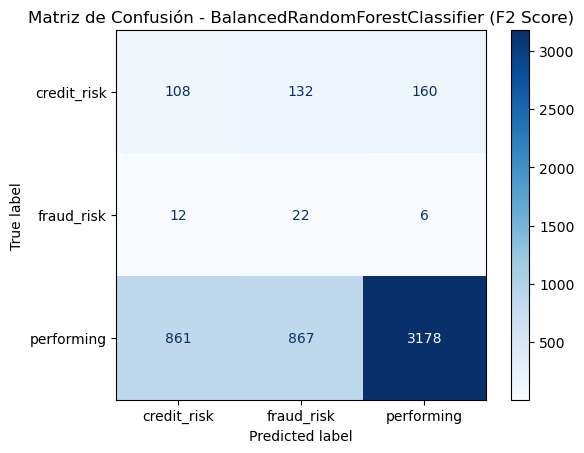

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer
import matplotlib.pyplot as plt

# 1. Definir el modelo base
brf = BalancedRandomForestClassifier(random_state=42, n_jobs=-1)

# 2. Definir los parámetros para el grid search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

# 3. Definir la métrica personalizada (f2_score)
f2_scorer = make_scorer(fbeta_score, beta=2, average='macro')

# 4. Configurar GridSearchCV
grid_search_brf = GridSearchCV(
    estimator=brf,
    param_grid=param_grid,
    scoring=f2_scorer,
    cv=5,
    verbose=2,
    n_jobs=-1
)

# 5. Entrenar el modelo
grid_search_brf.fit(X_train, y_train_encoded)

# 6. Predecir
y_pred_brf = grid_search_brf.predict(X_test)

# 7. Evaluación
print(" Mejores parámetros encontrados:", grid_search_brf.best_params_)
print("\n Matriz de confusión:")
print(confusion_matrix(y_test_encoded, y_pred_brf))
print("\n Reporte de clasificación:")
print(classification_report(y_test_encoded, y_pred_brf, target_names=le.classes_))

# 8. Visualización
ConfusionMatrixDisplay.from_estimator(
    grid_search_brf.best_estimator_,
    X_test,
    y_test_encoded,
    display_labels=le.classes_,
    cmap="Blues"
)
plt.title("Matriz de Confusión - BalancedRandomForestClassifier (F2 Score)")
plt.show()



#### MLP

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from collections import Counter

# --- Escalado ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Rebalanceo ---
rus = RandomUnderSampler(sampling_strategy={2: 3000}, random_state=42)
X_down, y_down = rus.fit_resample(X_train_scaled, y_train_encoded)

smt = SMOTETomek(sampling_strategy={0: 3600, 1: 5900}, random_state=42)
X_resampled, y_resampled = smt.fit_resample(X_down, y_down)

print(" Distribución final:", Counter(y_resampled))

# --- Convertir a tensores ---
X_train_tensor = torch.tensor(X_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_resampled, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# --- Definición de la red neuronal ---
class MLP(nn.Module):
    def __init__(self, input_size, hidden1=128, hidden2=64, output_size=3):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden2, output_size)
        )

    def forward(self, x):
        return self.model(x)

# --- Inicialización ---
input_size = X_train_tensor.shape[1]
model = MLP(input_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- Entrenamiento ---
epochs = 45
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {loss.item():.4f}")

# --- Evaluación ---
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    predicted_labels = torch.argmax(predictions, dim=1).numpy()

# --- Métricas ---
print(" Matriz de confusión:\n", confusion_matrix(y_test_encoded, predicted_labels))
print("\n Reporte de clasificación:\n", classification_report(
    y_test_encoded,
    predicted_labels,
    target_names=le.classes_
))


📊 Distribución final: Counter({1: 5900, 0: 3504, 2: 2904})
Epoch [5/45] - Loss: 1.0366
Epoch [10/45] - Loss: 0.9997
Epoch [15/45] - Loss: 0.9604
Epoch [20/45] - Loss: 0.9167
Epoch [25/45] - Loss: 0.8695
Epoch [30/45] - Loss: 0.8280
Epoch [35/45] - Loss: 0.7866
Epoch [40/45] - Loss: 0.7436
Epoch [45/45] - Loss: 0.7086
📊 Matriz de confusión:
 [[ 157  111  132]
 [  11   23    6]
 [1364  843 2699]]

📄 Reporte de clasificación:
               precision    recall  f1-score   support

 credit_risk       0.10      0.39      0.16       400
  fraud_risk       0.02      0.57      0.05        40
  performing       0.95      0.55      0.70      4906

    accuracy                           0.54      5346
   macro avg       0.36      0.51      0.30      5346
weighted avg       0.88      0.54      0.65      5346



#### Deep MLP

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from collections import Counter

# --- Escalado ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Rebalanceo ---
rus = RandomUnderSampler(sampling_strategy={2: 14000}, random_state=42)
X_down, y_down = rus.fit_resample(X_train_scaled, y_train_encoded)

smt = SMOTETomek(sampling_strategy={0: 13600, 1: 12900}, random_state=42)
X_resampled, y_resampled = smt.fit_resample(X_down, y_down)

print(" Distribución final:", Counter(y_resampled))

# --- Tensores ---
X_train_tensor = torch.tensor(X_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_resampled, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# --- Red neuronal profunda ---
class DeepMLP(nn.Module):
    def __init__(self, input_size, output_size=3):
        super(DeepMLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        return self.network(x)

# --- Focal Loss ---
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.alpha is not None:
            alpha_t = self.alpha.gather(0, targets)
            focal_loss *= alpha_t

        return focal_loss.mean()

# --- Inicialización del modelo ---
input_size = X_train_tensor.shape[1]
model = DeepMLP(input_size)
optimizer = optim.Adam(model.parameters(), lr=0.0008)

# --- Alpha (pesos inversos) ---
class_counts = Counter(y_resampled)
total = sum(class_counts.values())
alpha = torch.tensor([
    total / class_counts[0],
    total / class_counts[1],
    total / class_counts[2]
], dtype=torch.float32)

# --- Usar focal loss con alpha y gamma ---
criterion = FocalLoss(gamma=2.0, alpha=alpha)

# --- Entrenamiento ---
epochs = 40
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {loss.item():.4f}")

# --- Evaluación ---
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    predicted_labels_deep = torch.argmax(predictions, dim=1).numpy()

# --- Métricas ---
print(" Matriz de confusión:\n", confusion_matrix(y_test_encoded, predicted_labels_deep))
print("\n Reporte de clasificación:\n", classification_report(
    y_test_encoded,
    predicted_labels_deep,
    target_names=['Credit Risk', 'Fraud Risk', 'Performing']
))


📊 Distribución final: Counter({2: 13993, 0: 13593, 1: 12900})
Epoch [5/40] - Loss: 1.4765
Epoch [10/40] - Loss: 1.2842
Epoch [15/40] - Loss: 1.1470
Epoch [20/40] - Loss: 1.0607
Epoch [25/40] - Loss: 0.9827
Epoch [30/40] - Loss: 0.9188
Epoch [35/40] - Loss: 0.8498
Epoch [40/40] - Loss: 0.7981
📊 Matriz de confusión:
 [[ 180   41  179]
 [  17   12   11]
 [1291  252 3363]]

📄 Reporte de clasificación:
               precision    recall  f1-score   support

 Credit Risk       0.12      0.45      0.19       400
  Fraud Risk       0.04      0.30      0.07        40
  Performing       0.95      0.69      0.80      4906

    accuracy                           0.66      5346
   macro avg       0.37      0.48      0.35      5346
weighted avg       0.88      0.66      0.74      5346



###  Doble modelo

✅ Train balanceado: Counter({1: 19620, 0: 19620})
📊 Test balanceado: Counter({1: 4906, 0: 4906})

📉 Matriz de Confusión - Performing vs No Performing (rebalanceado en test)


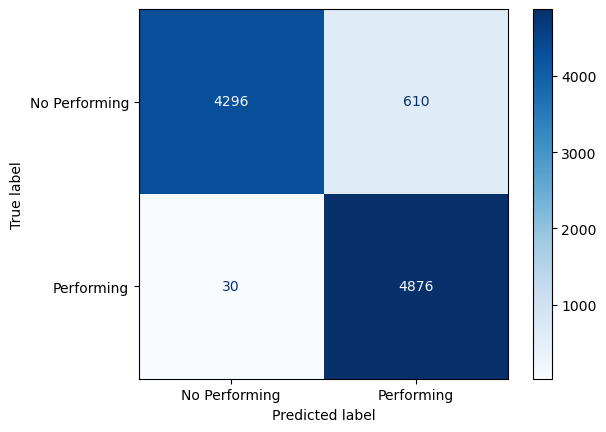

               precision    recall  f1-score   support

No Performing       0.99      0.88      0.93      4906
   Performing       0.89      0.99      0.94      4906

     accuracy                           0.93      9812
    macro avg       0.94      0.93      0.93      9812
 weighted avg       0.94      0.93      0.93      9812


📊 Matriz de Confusión - Credit vs Fraud (solo No Performing predichos)


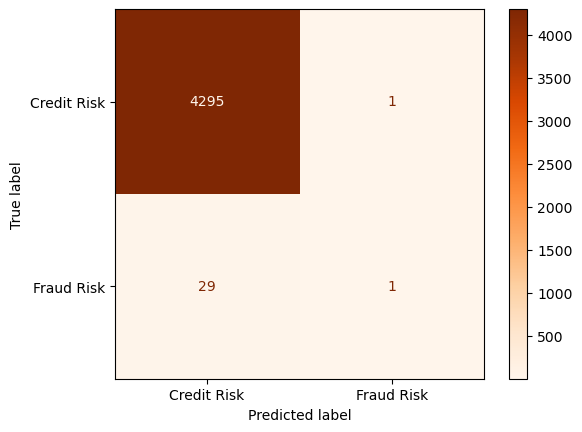

              precision    recall  f1-score   support

 Credit Risk       0.99      1.00      1.00      4296
  Fraud Risk       0.50      0.03      0.06        30

    accuracy                           0.99      4326
   macro avg       0.75      0.52      0.53      4326
weighted avg       0.99      0.99      0.99      4326



In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# 1. Convertimos y_train_encoded e y_test_encoded a binario
y_train_bin = np.where(y_train_encoded == 2, 1, 0)  # Performing = 1, No Performing = 0
y_test_bin = np.where(y_test_encoded == 2, 1, 0)

# 2. SMOTE en el train binario
smote_bin = SMOTE(sampling_strategy=1.0, random_state=42)
X_train_bal, y_train_bal = smote_bin.fit_resample(X_train, y_train_bin)
print("✅ Train balanceado:", Counter(y_train_bal))

# 3. SMOTE en el test binario (solo validación)
X_test_bal, y_test_bal = smote_bin.fit_resample(X_test, y_test_bin)
print("📊 Test balanceado:", Counter(y_test_bal))

# 4. Modelo 1: Performing vs No Performing
model_bin = RandomForestClassifier(random_state=42)
model_bin.fit(X_train_bal, y_train_bal)
y_pred_bin = model_bin.predict(X_test_bal)

# 5. Evaluación Performing vs No Performing
print("\n📉 Matriz de Confusión - Performing vs No Performing (rebalanceado en test)")
ConfusionMatrixDisplay.from_predictions(y_test_bal, y_pred_bin,
                                        display_labels=["No Performing", "Performing"],
                                        cmap="Blues")
plt.show()
print(classification_report(y_test_bal, y_pred_bin, target_names=["No Performing", "Performing"]))

# 6. Subconjunto de test predicho como No Performing
X_test_sub = X_test_bal[y_pred_bin == 0]
y_test_sub = y_test_bal[y_pred_bin == 0]  # ⚠️ usar etiquetas rebalanceadas

# 7. Subconjunto de entrenamiento con clases 0 y 1
mask_train = (y_train_encoded == 0) | (y_train_encoded == 1)
X_train_sub = X_train[mask_train]
y_train_sub = y_train_encoded[mask_train]

# 8. Modelo 2: Credit vs Fraud
model_riesgo = RandomForestClassifier(random_state=42)
model_riesgo.fit(X_train_sub, y_train_sub)
y_pred_sub = model_riesgo.predict(X_test_sub)

# 9. Evaluación Credit vs Fraud
print("\n📊 Matriz de Confusión - Credit vs Fraud (solo No Performing predichos)")
ConfusionMatrixDisplay.from_predictions(y_test_sub, y_pred_sub,
                                        display_labels=["Credit Risk", "Fraud Risk"],
                                        cmap="Oranges")
plt.show()
print(classification_report(y_test_sub, y_pred_sub,
                            target_names=["Credit Risk", "Fraud Risk"]))


✅ Train balanceado (binario): Counter({1: 19620, 0: 19620})
📊 Test balanceado (binario): Counter({1: 4906, 0: 4906})

📉 Matriz de Confusión - Performing vs No Performing (rebalanceado en test)


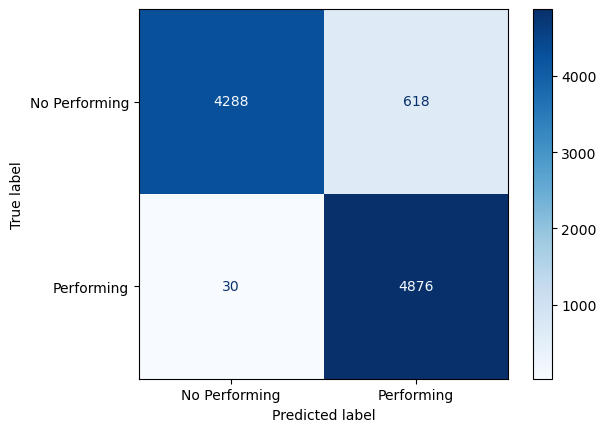

               precision    recall  f1-score   support

No Performing       0.99      0.87      0.93      4906
   Performing       0.89      0.99      0.94      4906

     accuracy                           0.93      9812
    macro avg       0.94      0.93      0.93      9812
 weighted avg       0.94      0.93      0.93      9812

✅ Train balanceado (riesgo): Counter({1: 1601, 0: 1601})

📊 Matriz de Confusión - Credit vs Fraud (solo No Performing predichos)


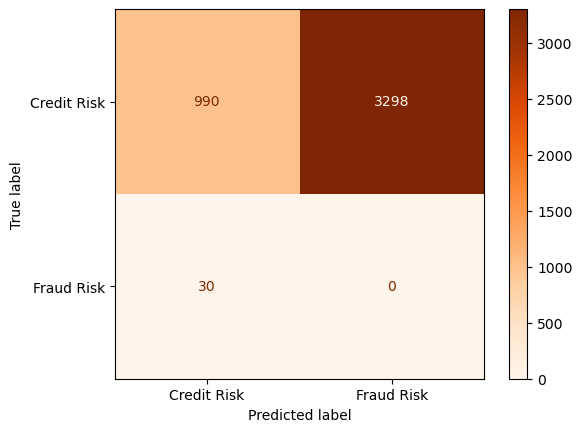

              precision    recall  f1-score   support

 Credit Risk       0.97      0.23      0.37      4288
  Fraud Risk       0.00      0.00      0.00        30

    accuracy                           0.23      4318
   macro avg       0.49      0.12      0.19      4318
weighted avg       0.96      0.23      0.37      4318



In [241]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# 1. Convertimos y_train_encoded e y_test_encoded a binario
y_train_bin = np.where(y_train_encoded == 2, 1, 0)  # Performing = 1, No Performing = 0
y_test_bin = np.where(y_test_encoded == 2, 1, 0)

# 2. SMOTE en el train binario
smote_bin = SMOTE(sampling_strategy=1.0, random_state=42)
X_train_bal, y_train_bal = smote_bin.fit_resample(X_train, y_train_bin)
print("✅ Train balanceado (binario):", Counter(y_train_bal))

# 3. SMOTE en el test binario (solo validación)
X_test_bal, y_test_bal = smote_bin.fit_resample(X_test, y_test_bin)
print("📊 Test balanceado (binario):", Counter(y_test_bal))

# 4. Modelo 1: Performing vs No Performing
model_bin = RandomForestClassifier(random_state=42)
model_bin.fit(X_train_bal, y_train_bal)
y_pred_bin = model_bin.predict(X_test_bal)

# 5. Evaluación Performing vs No Performing
print("\n📉 Matriz de Confusión - Performing vs No Performing (rebalanceado en test)")
ConfusionMatrixDisplay.from_predictions(y_test_bal, y_pred_bin,
                                        display_labels=["No Performing", "Performing"],
                                        cmap="Blues")
plt.show()
print(classification_report(y_test_bal, y_pred_bin, target_names=["No Performing", "Performing"]))

# 6. Subconjunto de test predicho como No Performing
X_test_sub = X_test_bal[y_pred_bin == 0]
y_test_sub = y_test_bal[y_pred_bin == 0]  # ⚠️ usar etiquetas rebalanceadas

# 7. Subconjunto de entrenamiento con clases 0 y 1
mask_train = (y_train_encoded == 0) | (y_train_encoded == 1)
X_train_sub = X_train[mask_train]
y_train_sub = y_train_encoded[mask_train]

# 8. SMOTE para Credit vs Fraud
smote_riesgo = SMOTE(random_state=42)
X_train_sub_bal, y_train_sub_bal = smote_riesgo.fit_resample(X_train_sub, y_train_sub)
print("✅ Train balanceado (riesgo):", Counter(y_train_sub_bal))

# 9. Modelo 2: Credit vs Fraud
model_riesgo = RandomForestClassifier(random_state=42)
model_riesgo.fit(X_train_sub_bal, y_train_sub_bal)
y_pred_sub = model_riesgo.predict(X_test_sub)

# 10. Evaluación Credit vs Fraud
print("\n📊 Matriz de Confusión - Credit vs Fraud (solo No Performing predichos)")
ConfusionMatrixDisplay.from_predictions(y_test_sub, y_pred_sub,
                                        display_labels=["Credit Risk", "Fraud Risk"],
                                        cmap="Oranges")
plt.show()
print(classification_report(y_test_sub, y_pred_sub,
                            target_names=["Credit Risk", "Fraud Risk"]))


✅ Train balanceado (riesgo): Counter({1: 1601, 0: 1601})
📊 Test balanceado (riesgo - validación): Counter({0: 19, 1: 19})

📊 Matriz de Confusión - Credit vs Fraud (con test rebalanceado)


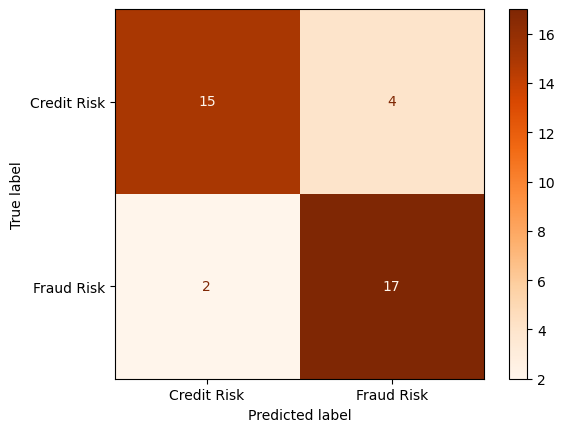

              precision    recall  f1-score   support

 Credit Risk       0.88      0.79      0.83        19
  Fraud Risk       0.81      0.89      0.85        19

    accuracy                           0.84        38
   macro avg       0.85      0.84      0.84        38
weighted avg       0.85      0.84      0.84        38



In [242]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# 1. Subconjunto de entrenamiento (solo credit_risk y fraud_risk)
mask_train = (y_train_encoded == 0) | (y_train_encoded == 1)
X_train_sub = X_train[mask_train]
y_train_sub = y_train_encoded[mask_train]

# 2. Predicciones originales sin rebalanceo (¡importante!)
y_pred_bin_original = model_bin.predict(X_test)  # modelo_bin viene del paso anterior

# 3. Subconjunto de test predicho como No Performing (sin usar X_test_bal)
X_test_sub = X_test[y_pred_bin_original == 0]
y_test_sub = y_test_encoded[y_pred_bin_original == 0]

# 4. Aplicamos SMOTE al train
smote_train = SMOTE(random_state=42)
X_train_sub_bal, y_train_sub_bal = smote_train.fit_resample(X_train_sub, y_train_sub)
print("✅ Train balanceado (riesgo):", Counter(y_train_sub_bal))

# 5. Aplicamos SMOTE al test (solo para validación)
mask_test = (y_test_sub == 0) | (y_test_sub == 1)
X_test_sub_val = X_test_sub[mask_test]
y_test_sub_val = y_test_sub[mask_test]

smote_test = SMOTE(random_state=42, k_neighbors=1)
X_test_sub_bal, y_test_sub_bal = smote_test.fit_resample(X_test_sub_val, y_test_sub_val)
print("📊 Test balanceado (riesgo - validación):", Counter(y_test_sub_bal))

# 6. Entrenamos el modelo
model_riesgo = RandomForestClassifier(n_estimators=500, max_depth=10,
                                      class_weight='balanced', random_state=42)

model_riesgo.fit(X_train_sub_bal, y_train_sub_bal)
y_pred_sub = model_riesgo.predict(X_test_sub_bal)

# 7. Evaluación final
print("\n📊 Matriz de Confusión - Credit vs Fraud (con test rebalanceado)")
ConfusionMatrixDisplay.from_predictions(y_test_sub_bal, y_pred_sub,
                                        display_labels=["Credit Risk", "Fraud Risk"],
                                        cmap="Oranges")
plt.show()
print(classification_report(y_test_sub_bal, y_pred_sub,
                            target_names=["Credit Risk", "Fraud Risk"]))


### Modelo binario

In [60]:
# Creamos nuevas variables binarias
y_train_bin = (y_train_encoded != le.transform(['performing'])[0]).astype(int)
y_test_bin = (y_test_encoded != le.transform(['performing'])[0]).astype(int)

# Ahora:
# - 0: performing → no_riesgo
# - 1: credit_risk o fraud_risk → riesgo
y_train_encoded


array([2, 1, 2, ..., 2, 2, 2])

🎯 Distribución original: Counter({0: 19620, 1: 1760})
📈 Distribución después de ADASYN: Counter({1: 19839, 0: 19620})


c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\xgboost\core.py:158: UserWarning: [09:16:03] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📉 Evaluación con threshold ajustado a 0.15:
[[1900 3006]
 [  75  365]]
              precision    recall  f1-score   support

   no_riesgo       0.96      0.39      0.55      4906
      riesgo       0.11      0.83      0.19       440

    accuracy                           0.42      5346
   macro avg       0.54      0.61      0.37      5346
weighted avg       0.89      0.42      0.52      5346



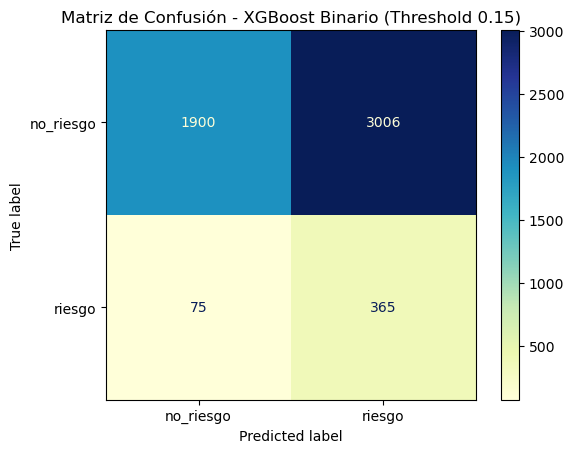

In [ ]:

from xgboost import XGBClassifier
from imblearn.over_sampling import ADASYN
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# 2. REBALANCEAR CON ADASYN
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train_bin)

print("Distribución original:", Counter(y_train_bin))
print("Distribución después de ADASYN:", Counter(y_train_resampled))

# 3. ENTRENAR XGBOOST BINARIO
scale_weight = Counter(y_train_bin)[0] / Counter(y_train_bin)[1]

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train_resampled, y_train_resampled)

# 4. AJUSTE DE THRESHOLD
y_proba = xgb_model.predict_proba(X_test)[:, 1]  # Probabilidad de clase 1 (riesgo)

threshold = 0.15 
y_pred_thresh = (y_proba >= threshold).astype(int)

# Evaluación
print(f"\n Evaluación con threshold ajustado a {threshold}:")
print(confusion_matrix(y_test_bin, y_pred_thresh))
print(classification_report(y_test_bin, y_pred_thresh, target_names=["no_riesgo", "riesgo"]))

ConfusionMatrixDisplay.from_predictions(
    y_test_bin, y_pred_thresh,
    display_labels=["no_riesgo", "riesgo"],
    cmap="YlGnBu"
)
plt.title(f"Matriz de Confusión - XGBoost Binario (Threshold {threshold})")
plt.show()




### SVM


📊 Matriz de confusión - SVM con class_weight='balanced':
[[ 158   17  225]
 [  17    6   17]
 [1050   69 3787]]

📄 Reporte de clasificación:
              precision    recall  f1-score   support

 credit_risk       0.13      0.40      0.19       400
  fraud_risk       0.07      0.15      0.09        40
  performing       0.94      0.77      0.85      4906

    accuracy                           0.74      5346
   macro avg       0.38      0.44      0.38      5346
weighted avg       0.87      0.74      0.79      5346



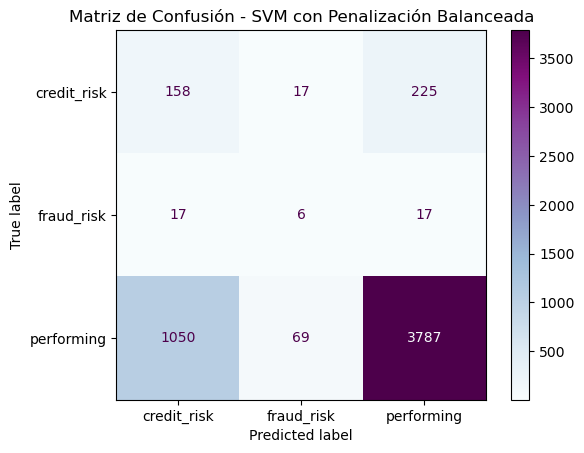

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Crear SVM con penalización por clase automática
svm_bal = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=1.0, class_weight='balanced', decision_function_shape='ovr', random_state=42)
)

# Entrenar
svm_bal.fit(X_train, y_train_encoded)

# Predecir
y_pred_svm_bal = svm_bal.predict(X_test)

# Evaluar
print("\n Matriz de confusión - SVM con class_weight='balanced':")
print(confusion_matrix(y_test_encoded, y_pred_svm_bal))
print("\n Reporte de clasificación:")
print(classification_report(y_test_encoded, y_pred_svm_bal, target_names=le.classes_))

# Visualización
ConfusionMatrixDisplay.from_predictions(
    y_test_encoded, y_pred_svm_bal,
    display_labels=le.classes_,
    cmap="BuPu"
)
plt.title("Matriz de Confusión - SVM con Penalización Balanceada")
plt.show()


### Modelo binario con redes neuronales

🎯 Distribución original: Counter({0: 19620, 1: 1760})
📈 Distribución después de SMOTE: Counter({0: 19620, 1: 19620})
Epoch [5/40] - Loss: 0.6438
Epoch [10/40] - Loss: 0.6115
Epoch [15/40] - Loss: 0.5913
Epoch [20/40] - Loss: 0.5725
Epoch [25/40] - Loss: 0.5567
Epoch [30/40] - Loss: 0.5358
Epoch [35/40] - Loss: 0.5157
Epoch [40/40] - Loss: 0.4926

📉 Evaluación con threshold = 0.2
[[1841 3065]
 [  77  363]]
               precision    recall  f1-score   support

   performing       0.96      0.38      0.54      4906
no_performing       0.11      0.82      0.19       440

     accuracy                           0.41      5346
    macro avg       0.53      0.60      0.36      5346
 weighted avg       0.89      0.41      0.51      5346



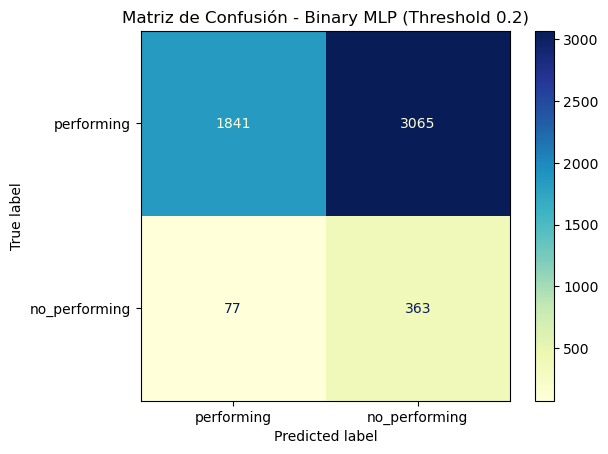

In [ ]:
# ==============================
# 1. LIBRERÍAS Y SETUP
# ==============================
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from collections import Counter

# ==============================
# 2. BINARIZAR LAS CLASES
# ==============================
# y_train_encoded: etiquetas originales multiclase
# performing = 2 → lo convertimos en clase 0
# credit_risk (0) y fraud_risk (1) → los convertimos en clase 1

y_train_bin = np.where(y_train_encoded == 2, 0, 1)
y_test_bin = np.where(y_test_encoded == 2, 0, 1)

print(" Distribución original:", Counter(y_train_bin))

# ==============================
# 3. ESCALADO
# ==============================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==============================
# 4. REBALANCEO CON SMOTE
# ==============================
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train_bin)

print(" Distribución después de SMOTE:", Counter(y_resampled))

# ==============================
# 5. TENSORES PARA PYTORCH
# ==============================
X_train_tensor = torch.tensor(X_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_resampled.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_bin.reshape(-1, 1), dtype=torch.float32)

# ==============================
# 6. MODELO BINARIO
# ==============================
class BinaryMLP(nn.Module):
    def __init__(self, input_size, hidden1=512, hidden2=128):
        super(BinaryMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden2, 1)  # Binario
        )

    def forward(self, x):
        return self.model(x)  # No aplicar sigmoid aquí (lo hace BCEWithLogitsLoss)

# ==============================
# 7. ENTRENAMIENTO
# ==============================
input_size = X_train_tensor.shape[1]
model = BinaryMLP(input_size)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 40
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {loss.item():.4f}")

# ==============================
# 8. EVALUACIÓN
# ==============================
model.eval()
with torch.no_grad():
    logits = model(X_test_tensor)
    probs = torch.sigmoid(logits).numpy().flatten()  # Probabilidad de clase 1 (no-performing)

# Ajustar el threshold según curva PR/F1
threshold = 0.2
y_pred_bin = (probs >= threshold).astype(int)

# ==============================
# 9. RESULTADOS
# ==============================
print(f"\n Evaluación con threshold = {threshold}")
print(confusion_matrix(y_test_bin, y_pred_bin))
print(classification_report(y_test_bin, y_pred_bin, target_names=["performing", "no_performing"]))

ConfusionMatrixDisplay.from_predictions(
    y_test_bin, y_pred_bin,
    display_labels=["performing", "no_performing"],
    cmap="YlGnBu"
)
plt.title(f"Matriz de Confusión - Binary MLP (Threshold {threshold})")
plt.show()

In [66]:
# ==============================
# 10. APLICAR RANDOM FOREST A CASOS DE RIESGO
# ==============================

# 1. Filtrar los datos clasificados como RIESGO por el modelo binario
X_test_riesgo = X_test[y_pred_bin == 1]
y_true_riesgo = y_test_encoded[y_pred_bin == 1]  # Etiquetas multiclase reales (0: credit, 1: fraud, 2: performing)

# 2. Predecir con el Random Forest entrenado
y_pred_riesgo_rf = grid_search.predict(X_test_riesgo)

# 3. Evaluar solo sobre los riesgos
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("📊 Reporte de clasificación SOLO en instancias de riesgo (binarias=1):")
print(classification_report(
    y_true_riesgo,
    y_pred_riesgo_rf,
    target_names=le.classes_  # Asegúrate que `le` tiene las clases ['credit_risk', 'fraud_risk', 'performing']
))

# 4. Matriz de confusión visual
ConfusionMatrixDisplay.from_predictions(
    y_true_riesgo,
    y_pred_riesgo_rf,
    display_labels=le.classes_,
    cmap="Oranges"
)
plt.title("Matriz de Confusión - Riesgo filtrado por MLP → Refinado por RF")
plt.show()


NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\kevin.vargas\AppData\Local\miniconda3\envs\pit2\lib\site-packages\sklearn\base.py:439: UserWarning: X does not 


📊 Reporte clasificación - Modelo Cascada
              precision    recall  f1-score   support

 credit_risk       0.08      0.30      0.12       400
  fraud_risk       0.02      0.70      0.03        40
  performing       0.96      0.38      0.54      4906

    accuracy                           0.37      5346
   macro avg       0.35      0.46      0.23      5346
weighted avg       0.89      0.37      0.50      5346



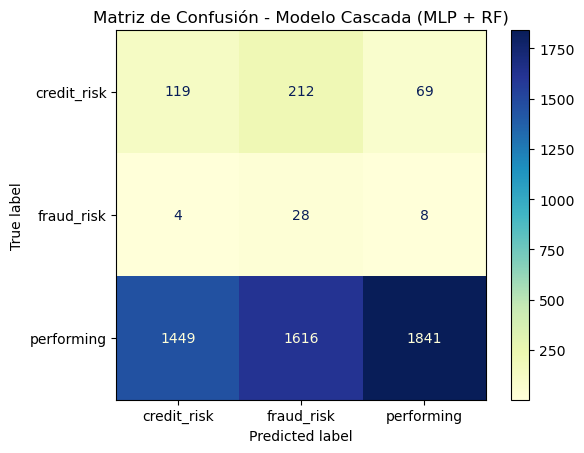

In [ ]:
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1️. Entrenar RandomForest solo con credit_risk y fraud_risk
mask_riesgo = (y_train_encoded != 2)  # Excluir performing
X_train_riesgo = X_train[mask_riesgo]
y_train_riesgo = y_train_encoded[mask_riesgo]  # Solo 0 y 1

# Rebalancear
rus = RandomUnderSampler(random_state=42)
X_down, y_down = rus.fit_resample(X_train_riesgo, y_train_riesgo)

smt = SMOTETomek(random_state=42)
X_train_rf, y_train_rf = smt.fit_resample(X_down, y_down)

# Entrenar el modelo Random Forest
rf_risk = RandomForestClassifier(
    class_weight={0: 5, 1: 30},  # Puedes afinar estos pesos
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf_risk.fit(X_train_rf, y_train_rf)

# 2. PREDICCIÓN EN CASCADA

# y_pred_bin: salida del MLP binario (ya entrenado)
# X_test: tu test original como DataFrame

final_preds = []

for i in range(X_test.shape[0]):
    if y_pred_bin[i] == 0:
        final_preds.append(2)  # performing directamente
    else:
        x_sample = X_test.iloc[i].values.reshape(1, -1)  # accedemos correctamente a la fila
        pred = rf_risk.predict(x_sample)[0]  # credit_risk (0) o fraud_risk (1)
        final_preds.append(pred)

final_preds = np.array(final_preds)

# 3️. EVALUACIÓN

print("\n Reporte clasificación - Modelo Cascada")
print(classification_report(y_test_encoded, final_preds, target_names=le.classes_))

ConfusionMatrixDisplay.from_predictions(
    y_test_encoded,
    final_preds,
    display_labels=le.classes_,
    cmap="YlGnBu"
)
plt.title("Matriz de Confusión - Modelo Cascada (MLP + RF)")
plt.show()


### Modelo stacking


📊 Reporte de clasificación - Modelo Stacking
              precision    recall  f1-score   support

 credit_risk       0.11      0.30      0.16       400
  fraud_risk       0.02      0.57      0.04        40
  performing       0.95      0.64      0.76      4906

    accuracy                           0.61      5346
   macro avg       0.36      0.50      0.32      5346
weighted avg       0.88      0.61      0.71      5346



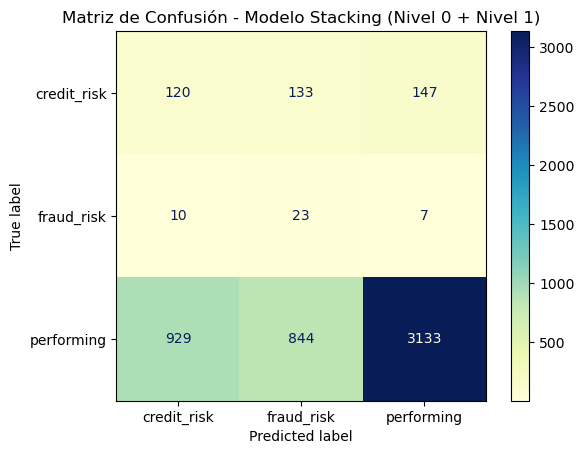

In [ ]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# =========================
# 1. DEFINIR MODELOS BASE
# =========================
estimators = [
    ('rf', RandomForestClassifier(
        class_weight={0: 10, 1: 40, 2: 2},
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    )),
    ('lr', Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
    ])),
    ('mlp', Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPClassifier(hidden_layer_sizes=(256, 128, 64),
                              activation='relu',
                              solver='adam',
                              alpha=0.0008,
                              learning_rate_init=0.001,
                              max_iter=200,
                              random_state=42))
    ]))
]

# =========================
# 2. DEFINIR METAMODELO (Nivel 1)
# =========================
final_estimator = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

# =========================
# 3. STACKING CLASSIFIER
# =========================
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# =========================
# 4. ENTRENAMIENTO
# =========================
stacking_clf.fit(X_train, y_train_encoded)

# =========================
# 5. PREDICCIÓN Y EVALUACIÓN
# =========================
y_pred_stack = stacking_clf.predict(X_test)

print("\n Reporte de clasificación - Modelo Stacking")
print(classification_report(y_test_encoded, y_pred_stack, target_names=le.classes_))

ConfusionMatrixDisplay.from_predictions(
    y_test_encoded,
    y_pred_stack,
    display_labels=le.classes_,
    cmap="YlGnBu"
)
plt.title("Matriz de Confusión - Modelo Stacking (Nivel 0 + Nivel 1)")
plt.show()


## 1.8 Elección del modelo

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

# Diccionario con los nombres de los modelos y sus predicciones
model_predictions = {
    'Deep MLP': predicted_labels_deep,
    'XGBoost': y_pred_xg3,
    'XGBoost (Threshold)': y_pred_adjusted,
    'Random Forest': y_pred_rf2,
    'Random Forest (Threshold)': y_pred_adjusted_rf,
    'Logistic Regression': y_pred_lr1,
    'Modelo binario Xgboost': y_pred_thresh,
    'Modelo binario red neuronal': y_pred_bin
}

# Etiquetas reales
true_labels_dict = {
    'Deep MLP': y_test_encoded,
    'XGBoost': y_test_encoded,
    'XGBoost (Threshold)': y_test_encoded,
    'Random Forest': y_test_encoded,
    'Random Forest (Threshold)': y_test_encoded,
    'Logistic Regression': y_test_encoded,
    'Modelo binario Xgboost': y_test_bin,
    'Modelo binario red neuronal': y_test_bin
}

# Nombres de las clases
labels_multiclass = ['credit_risk', 'fraud_risk', 'performing']
labels_binary = ['no_risk', 'risk']  

# Lista para guardar resultados
all_results = []

for model_name, y_pred in model_predictions.items():
    y_true = true_labels_dict[model_name]
    
    if model_name.startswith("Modelo binario"):
        report = classification_report(y_true, y_pred, output_dict=True, target_names=labels_binary)
        for class_name in labels_binary:
            all_results.append({
                'Model': model_name,
                'Class': class_name,
                'Precision': report[class_name]['precision'],
                'Recall': report[class_name]['recall'],
                'F1-Score': report[class_name]['f1-score']
            })
    else:
        report = classification_report(y_true, y_pred, output_dict=True, target_names=labels_multiclass)
        for class_name in labels_multiclass:
            all_results.append({
                'Model': model_name,
                'Class': class_name,
                'Precision': report[class_name]['precision'],
                'Recall': report[class_name]['recall'],
                'F1-Score': report[class_name]['f1-score']
            })

# Crear DataFrame
df_summary = pd.DataFrame(all_results)

# Mostrar tabla con formato 
df_summary.style.format({
    'Precision': "{:.4f}",
    'Recall': "{:.4f}",
    'F1-Score': "{:.4f}"
})


In [85]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

# Diccionario con los nombres de los modelos y sus predicciones
model_predictions = { 
    'Normal MLP':predicted_labels,
    'Deep MLP': predicted_labels_deep,
    'XGBoost': y_pred_xg3,
    'XGBoost (Threshold)': y_pred_adjusted,
    'Random Forest': y_pred_rf2,
    'Random Forest (Threshold)': y_pred_adjusted_rf,
    'Balanced Random Forest': y_pred_brf,
    'Logistic Regression': y_pred_lr1,
    'Modelo stacking': y_pred_stack,
    'Modelo binario Xgboost': y_pred_thresh,
    'Modelo binario red neuronal': y_pred_bin,
    'Modelo cascada': final_preds
}

# Etiquetas reales
true_labels_dict = {
    'Normal MLP': y_test_encoded,
    'Deep MLP': y_test_encoded,
    'XGBoost': y_test_encoded,
    'XGBoost (Threshold)': y_test_encoded,
    'Random Forest': y_test_encoded,
    'Random Forest (Threshold)': y_test_encoded,
    'Balanced Random Forest': y_test_encoded,
    'Logistic Regression': y_test_encoded,
    'Modelo stacking': y_test_encoded,
    'Modelo binario Xgboost': y_test_bin,
    'Modelo binario red neuronal': y_test_bin,
    'Modelo cascada': y_test_encoded
}

# Nombres de las clases
labels_multiclass = ['credit_risk', 'fraud_risk', 'performing']
labels_binary = ['no_risk', 'risk']  

# Lista para guardar resultados
all_results = []

for model_name, y_pred in model_predictions.items():
    y_true = true_labels_dict[model_name]
    acc = accuracy_score(y_true, y_pred)
    
    if model_name.startswith("Modelo binario"):
        report = classification_report(y_true, y_pred, output_dict=True, target_names=labels_binary)
        for class_name in labels_binary:
            all_results.append({
                'Model': model_name,
                'Class': class_name,
                'Precision': report[class_name]['precision'],
                'Recall': report[class_name]['recall'],
                'F1-Score': report[class_name]['f1-score'],
                'Accuracy': acc
            })
    else:
        report = classification_report(y_true, y_pred, output_dict=True, target_names=labels_multiclass)
        for class_name in labels_multiclass:
            all_results.append({
                'Model': model_name,
                'Class': class_name,
                'Precision': report[class_name]['precision'],
                'Recall': report[class_name]['recall'],
                'F1-Score': report[class_name]['f1-score'],
                'Accuracy': acc
            })

# Crear DataFrame
df_summary = pd.DataFrame(all_results)

# Función para resaltar los mejores valores por columna
def highlight_max_in_column(column):
    is_max = column == column.max()
    return ['background-color: lightcoral' if val else '' for val in is_max]

# Mostrar tabla con formato
df_summary.style.format({
    'Precision': "{:.4f}",
    'Recall': "{:.4f}",
    'F1-Score': "{:.4f}",
    'Accuracy': "{:.4f}"
}).apply(highlight_max_in_column, subset=['Precision']) \
  .apply(highlight_max_in_column, subset=['Recall']) \
  .apply(highlight_max_in_column, subset=['F1-Score']) \
  .apply(highlight_max_in_column, subset=['Accuracy'])


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

# Diccionario con los nombres de los modelos y sus predicciones
model_predictions = { 
    'Normal MLP': predicted_labels,
    'Deep MLP': predicted_labels_deep,
    'XGBoost': y_pred_xg3,
    'XGBoost (Threshold)': y_pred_adjusted,
    'Random Forest': y_pred_rf2,
    'Random Forest (Threshold)': y_pred_adjusted_rf,
    'Balanced Random Forest': y_pred_brf,
    'Logistic Regression': y_pred_lr1,
    'Modelo stacking': y_pred_stack,
    'Modelo binario Xgboost': y_pred_thresh,
    'Modelo binario red neuronal': y_pred_bin,
    'Modelo cascada': final_preds
}

# Etiquetas reales
true_labels_dict = {
    'Normal MLP': y_test_encoded,
    'Deep MLP': y_test_encoded,
    'XGBoost': y_test_encoded,
    'XGBoost (Threshold)': y_test_encoded,
    'Random Forest': y_test_encoded,
    'Random Forest (Threshold)': y_test_encoded,
    'Balanced Random Forest': y_test_encoded,
    'Logistic Regression': y_test_encoded,
    'Modelo stacking': y_test_encoded,
    'Modelo binario Xgboost': y_test_bin,
    'Modelo binario red neuronal': y_test_bin,
    'Modelo cascada': y_test_encoded
}

# Nombres de las clases
labels_multiclass = ['credit_risk', 'fraud_risk', 'performing']
labels_binary = ['no_risk', 'risk']

# Lista para guardar resultados
all_results = []

for model_name, y_pred in model_predictions.items():
    y_true = true_labels_dict[model_name]
    acc = accuracy_score(y_true, y_pred)
    
    if model_name.startswith("Modelo binario"):
        report = classification_report(y_true, y_pred, output_dict=True, target_names=labels_binary)
        for class_name in labels_binary:
            all_results.append({
                'Model': model_name,
                'Class': class_name,
                'Precision': report[class_name]['precision'],
                'Recall': report[class_name]['recall'],
                'F1-Score': report[class_name]['f1-score'],
                'Accuracy': acc
            })
    else:
        report = classification_report(y_true, y_pred, output_dict=True, target_names=labels_multiclass)
        for class_name in labels_multiclass:
            all_results.append({
                'Model': model_name,
                'Class': class_name,
                'Precision': report[class_name]['precision'],
                'Recall': report[class_name]['recall'],
                'F1-Score': report[class_name]['f1-score'],
                'Accuracy': acc
            })

# Crear DataFrame
df_summary = pd.DataFrame(all_results)

# Identificar el índice de la fila con mayor Recall en 'fraud_risk'
fraud_risk_rows = df_summary[df_summary['Class'] == 'fraud_risk']
idx_max_recall_fraud = fraud_risk_rows['Recall'].idxmax()

# Función para resaltar los máximos por columna
def highlight_max_in_column(column):
    is_max = column == column.max()
    return ['background-color: lightcoral' if val else '' for val in is_max]

# Función para resaltar toda la fila del mejor Recall en fraud_risk
def highlight_row_if_best_fraud(row):
    return ['background-color: blue' if row.name == idx_max_recall_fraud else '' for _ in row]

# Mostrar tabla con todo el formato
df_summary.style.format({
    'Precision': "{:.4f}",
    'Recall': "{:.4f}",
    'F1-Score': "{:.4f}",
    'Accuracy': "{:.4f}"
}).apply(highlight_max_in_column, subset=['Precision']) \
  .apply(highlight_max_in_column, subset=['Recall']) \
  .apply(highlight_max_in_column, subset=['F1-Score']) \
  .apply(highlight_max_in_column, subset=['Accuracy']) \
  .apply(highlight_row_if_best_fraud, axis=1)
